# Atick and Redlich, 1990. "Towards a theory of early visual processing."  
  
  Here we simulate the receptive field that minimizes redundancy subject to a total variance restraint, translation invariance, and minimum information requirements.

In [133]:
import numpy as np
#from numpy.fft import fft
import info_theory_functions as info
from scipy.optimize import minimize
from scipy import fft, arange
from scipy.stats import sem
from random import randint
from cmath import polar
from numpy.fft import fft2
from numpy.fft import fftshift
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from lnl_model_functions import *


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Equation 2.4. The one positive solution for the optimal transfer function:

In [134]:
def soln(R_0, inputNoise, outputNoise, lagrangeMultiplier):
    '''R_0 is input covariance matrix
       R is R_0 + N^2 delta_n,m'''
    #R = np.array(R_0) + inputNoise**2 #* np.eye(*R_0.shape)
    return (outputNoise/inputNoise)*np.sqrt([0.5*(r0/(r0+inputNoise**2))*(1 + np.sqrt(1+(2*lagrangeMultiplier*inputNoise**2)/r0))-1 for r0 in R_0])

In [135]:
filt = soln([1/f for f in np.linspace(0.1,100,100)], 0.1, 0.4, 2.6197)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


In [136]:
plot(filt)
mpld3.display()

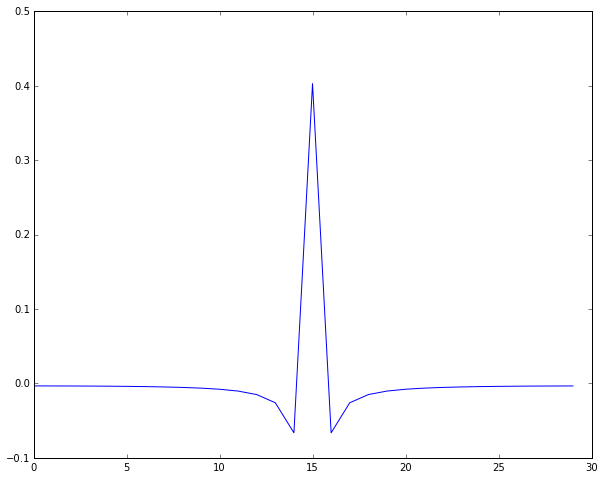

In [137]:
plot(np.fft.ifftshift(np.fft.ifft(filt[:30])))

In [138]:
def getLambda(R_0, inputNoise, outputNoise):
    def lhs(lam):
        return sum(np.log([np.sqrt(r/(2*lam*inputNoise**2))+np.sqrt(1+(r/2*lam*inputNoise**2)) for r in R_0]))
    R = np.array(R_0) + inputNoise**2
    rhs = 0.5*sum(np.log([(r*(inputNoise**2 + outputNoise**2))/(inputNoise**2 * (r + outputNoise**2)) for r in R]))
    
    def difference(lam):
        return abs(lhs(lam)-rhs)
    
    lam = 5*rand(1)
    res = minimize(difference, x0=lam, method='nelder-mead')
    
    return res.x, res.fun

In [139]:
(lam, err) = getLambda([1/f for f in np.linspace(0.1,100,100)], 0.1, 0.4)

In [140]:
lam

array([ 2.6197504])

In [141]:
err

5.1231077257796187e-05

In [142]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

In [143]:
from lnl_model_functions import *

In [144]:
def oneGaussian(x, original):
    sigma1,sigma2,strength1,strength2 = x
    xs = linspace(-5,5,len(original))
    ourGaussian = abs(strength1)*gaussian(x=xs, sigma=abs(sigma1)) - abs(strength2)*gaussian(x=xs, sigma=abs(sigma2))
    return ourGaussian

In [145]:
def oneGaussiansError(x,original):
    ourGaussian = oneGaussian(x, original)
    return sum(abs(ourGaussian-original))

In [146]:
cOpt = real(np.fft.ifftshift(np.fft.ifft(filt[:30])))

In [147]:
def fitGaussians(strength1,strength2,sigma1,sigma2):
    original=filt
    #sigma1,sigma2,strength1,strength2 = x
    xs = linspace(-5,5,len(original))
    ourGaussian = abs(strength1)*gaussian(x=xs, sigma=abs(sigma1)) - abs(strength2)*gaussian(x=xs, sigma=abs(sigma2))
    
    #print sum(abs(ourGaussian-original)) #oneGaussiansError([strength1,strength2,sigma1,sigma2],original)
    print oneGaussiansError([sigma1, sigma2, strength1, strength2], original)

    plot(original,'k',linewidth=3)
    plot(ourGaussian,'r',linewidth=2,alpha=0.8)
    
    return ourGaussian
    

In [148]:
w = interactive(fitGaussians, strength1=0.04, strength2=0.9, sigma1=0.15, sigma2=3.2)

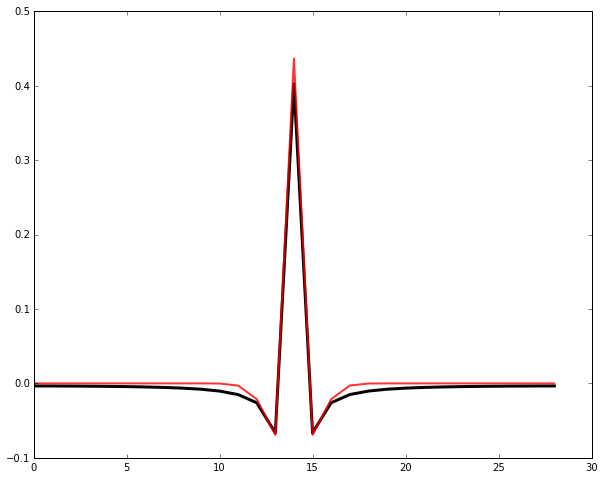

In [149]:
original=cOpt[1:]
strength1=0.034
strength2=0.105
sigma1=0.1
sigma2=0.4
xs = linspace(-5,5,len(original))
ourGaussian = abs(strength1)*gaussian(x=xs, sigma=abs(sigma1)) - abs(strength2)*gaussian(x=xs, sigma=abs(sigma2))
plot(original,'k',linewidth=3)
plot(ourGaussian,'r',linewidth=2,alpha=0.8)

In [150]:
oneGaussiansError([sigma1, sigma2, strength1, strength2], original)

0.18720730823350906

# With the amplitude spectrum from natural images

In [151]:
im_path = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd13A' # flood plain, water, horizon
#im_path = '/Users/lmcintosh/Documents/Natural_Images/RawData/cd01A' # baboons, trees, bushes

In [152]:
ls -1 $im_path | wc -l

     156


In [153]:
def load_images(path, numImages, patchSize=None, acceptedExtensions=['.imc','LUM.mat'], square=False, normalize='subtract'):
    from os import listdir
    from os.path import isfile, join
    import array as ar
    import scipy.io
    
    allfiles = []
    for ext in acceptedExtensions:
        allfiles = allfiles + [f for f in listdir(path) if isfile(join(path,f)) and ext in f]
    if len(allfiles) < numImages:
        print 'Only ' + str(len(allfiles)) + ' files in directory.'
    names    = allfiles[:numImages]
    patches  = []

    for im in names:
        if '.imc' in im:
            fin = open(path+'/'+im, 'rb')
            s   = fin.read()
            fin.close()
            arr = ar.array('H', s)
            arr.byteswap()
            img = np.array(arr, dtype='uint16').reshape(1024,1536)
        elif '.mat' in im:
            fin = scipy.io.loadmat(path+'/'+im)
            arr = fin['LUM_Image']
            # make 0 to 255
            arr = arr - min(arr.flat)
            arr = 255.*arr/max(arr.flat)
            img = np.array(arr, dtype='uint16')
            
        # make patches
        if patchSize:
            img_center = [np.shape(img)[0]/2,np.shape(img)[1]/2]
            img        = img[img_center[0]-patchSize/2:img_center[0]+patchSize/2,img_center[1]-patchSize/2:img_center[1]+patchSize/2]
            
        if square:
            N = min(shape(img))
            N = N - (N % 2) # make even
            img = img[:N,:N]
        
        if normalize == 'subtract':
            # normalize to unit variance and zero mean (originally I did these in opposite order, but this
            # is the official z-scoring order I believe)
            img -= np.mean(img)
            patches.append(img/np.std(img))
        elif normalize == 'divisive':
            # normalize by the mean
            patches.append(img/np.mean(img))
        else:
            patches.append(img)

    return patches

In [154]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (phi, rho)

In [155]:
def rotavg(im):
    '''im can be square 2d numpy array'''
    imShape = shape(im) # NNM
    N       = imShape[0]
    X, Y    = np.meshgrid(range(-N//2,N//2),range(-N//2,N//2))

    theta, rho = cart2pol(X,Y);
    rho = rho.round()
    f   = [mean(im[np.where(rho==r)]) for r in range(N//2+1)] 
        
    return f

In [156]:
def spectrum2d(arr, Fs=1000.0, frequencyFlag=True):
    amp = abs(fftshift(fft2(arr)))/np.prod(arr.shape)
    amp = rotavg(amp)
    n = len(amp)
    #amp = amp/n
    k = arange(n)
    T = n/Fs
    frq = k/(2*T) # two sides frequency range
    #frq = frq[range(n/2)] # one side frequency range
    
    if frequencyFlag:
        #return (frq, [a/n**2 for a in amp])  # should n be squared?
        return (frq, amp)
    else:
        #return [a/n**2 for a in amp]  # should n be squared?
        return amp

## Load original images

In [157]:
numImages = 100
patchSize = None
pixelsToDeg = 92./2
normalize = 'divisive'
averageGanglionSize = 1.5*pixelsToDeg+1 # in pixels

In [158]:
patches = load_images(im_path, numImages, patchSize, square=True, normalize=normalize)

Only 78 files in directory.


## Sample image in degrees

In [159]:
degAxes = [i/pixelsToDeg for i in xrange(patches[0].shape[0])]

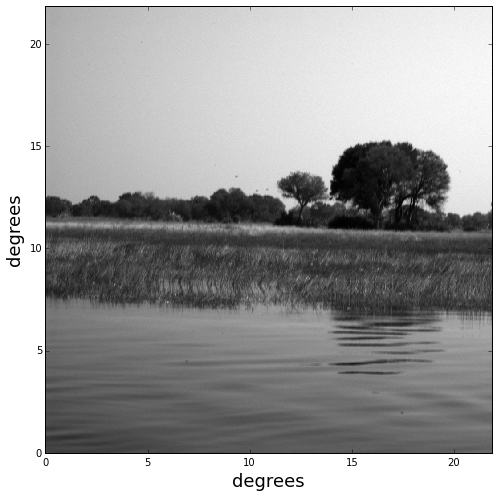

In [160]:
imshow(patches[13], extent=[np.min(degAxes), np.max(degAxes), np.min(degAxes), np.max(degAxes)])
xlabel('degrees',fontsize=18)
ylabel('degrees',fontsize=18)
savefig('example_natural_image.jpg')

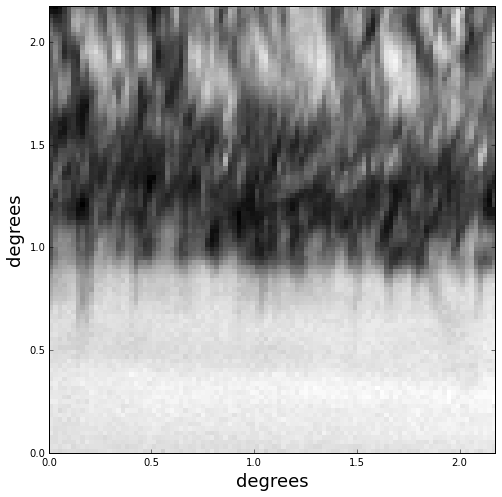

In [161]:
leftx = 300 + -1 + 10 + 18 + -7 - 19
topy  = 600 + 7 + 10 + 8 + -13 + 11
imPixels = 100
smallPatchExtent = imPixels / pixelsToDeg # same as imPixels/pixelsToDeg

imshow(patches[13][topy:topy+imPixels, leftx:leftx+imPixels], extent=[0, smallPatchExtent, 0, smallPatchExtent])
xlabel('degrees',fontsize=18)
ylabel('degrees',fontsize=18)
savefig('example_image_patch6.jpg')

In [162]:
amp = abs(fftshift(fft2(patches[0])))
rot = rotavg(amp)
print (shape(amp), shape(rot))

((1006, 1006), (504,))


## log 2d FFT plot of this sample image

#### Highest frequency is then 1/degree_spacing

In [163]:
samplingRate = pixelsToDeg    # Fs
spacing      = 1./pixelsToDeg # T
highest_freq = 1./(2*spacing)

print 'The sampling rate is %s pixels per degree.' %(samplingRate)
print 'The images are sampled at %f degree spacing.' %(spacing)
print 'Highest frequency should be %s 1/deg.' %(highest_freq)

The sampling rate is 46.0 pixels per degree.
The images are sampled at 0.021739 degree spacing.
Highest frequency should be 23.0 1/deg.


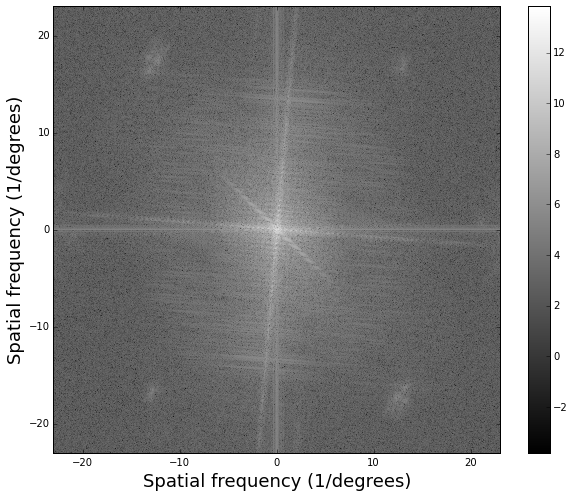

In [164]:
imshow(log(amp), extent=[-highest_freq, highest_freq, -highest_freq, highest_freq])
colorbar()
ylabel('Spatial frequency (1/degrees)',fontsize=18)
xlabel('Spatial frequency (1/degrees)',fontsize=18)

### Compute rotationally averaged amplitude spectrum

In [165]:
allRot  = [spectrum2d(p,Fs=pixelsToDeg,frequencyFlag=False) for p in patches]
specRot = mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],Fs=pixelsToDeg,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors = error
originalFreqs = frqRot

In [166]:
print 'Maximum frequency is %f, should be %f' %(np.max(originalFreqs), highest_freq)

Maximum frequency is 22.954365, should be 23.000000


In [167]:
print 'Minimum frequency is %f, should be %f' %(originalFreqs[1], 1./np.max(degAxes))

Minimum frequency is 0.045635, should be 0.045771


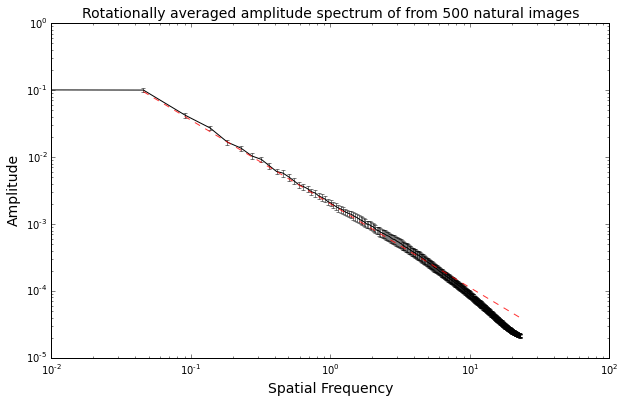

In [168]:
fig,ax = subplots()
fig.set_size_inches((10,6))

ax.errorbar(originalFreqs, originalSpectra, yerr=originalErrors, fmt='none', ecolor='k', capsize=2, capthick=1, alpha=0.5)
ax.plot(originalFreqs, originalSpectra, color='k', alpha=0.99)
# ax.plot(originalFreqs, [1.3/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
# ax.plot(originalFreqs, [0.02/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
ax.plot(originalFreqs[1:], [0.002/f**1.25 for f in originalFreqs[1:]], color='r', linestyle='--', alpha=0.8)

ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')

ax.set_title('Rotationally averaged amplitude spectrum of from 500 natural images', fontsize=14)
ax.set_xlabel('Spatial Frequency', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

#ylim([10e-7,10e-1])
# ylim([10e-4,10e1])
#ylim([10e-5,1])
#savefig('Figures/00 Average power spectrum of original images.png')

#### Sanity check on magnitude scale

In [169]:
print 'Actual DC component is %s, should be %f. E.g., the mean of the first patch is %s' %(originalSpectra[0], np.mean(patches), abs(fft2(patches[0])[0,0]/np.prod(patches[0].shape)))

Actual DC component is 1.0, should be 1.000000. E.g., the mean of the first patch is 1.0


In [170]:
abs(fft2(patches[0]))[0,0]

1012035.9999999998

Resolution in 1/degrees

In [171]:
pixelsToDeg/patches[0].shape[0]

0.04572564612326044

In [172]:
def uniqueSoln(R_0, inputNoise, outputNoise, verbose=True):
    '''R_0 is input covariance matrix
       R is R_0 + N^2 delta_n,m'''
    #R = np.array(R_0) + inputNoise**2 #* np.eye(*R_0.shape)
    
    lam, err = getLambda(R_0, inputNoise, outputNoise)
    if verbose:
        print 'The error from this choice of Lagrangian multiplier is %s.' %(err)
    
    return (outputNoise/inputNoise)*np.sqrt([0.5*(r0/(r0+inputNoise**2))*(1 + np.sqrt(1+(2*lam*inputNoise**2)/r0))-1 for r0 in R_0])

### Get filter with ampitude spectrum from natural scenes

In [173]:
filt = uniqueSoln(originalSpectra, 0.1, 0.1)

The error from this choice of Lagrangian multiplier is 6.04625247647e-08.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


In [174]:
lam, err = getLambda(originalSpectra, 0.1, 0.4)

In [175]:
print err

4.83760427095e-06


In [176]:
filt = soln(originalSpectra, 0.1, 0.4, lam)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/matplotlib/scale.py:100: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


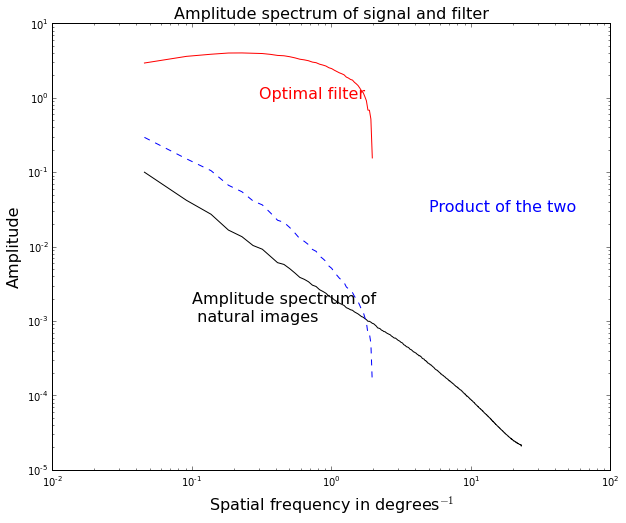

In [177]:
plot(originalFreqs[1:],filt[1:],'r')
plot(originalFreqs[1:],originalSpectra[1:],'k')
plot(originalFreqs[1:],[f*originalSpectra[idf] for idf,f in enumerate(filt)][1:],'b--')
yscale('log')
xscale('log')
title('Amplitude spectrum of signal and filter',fontsize=16)
xlabel('Spatial frequency in degrees' + r'$^{-1}$',fontsize=16)
ylabel('Amplitude',fontsize=16)
annotate('Optimal filter',(0.3,10e-1),fontsize=16,color='r')
annotate('Amplitude spectrum of \n natural images',(0.1,.001),fontsize=16,color='k')
annotate('Product of the two',(5.,3*10e-3),fontsize=16,color='b')

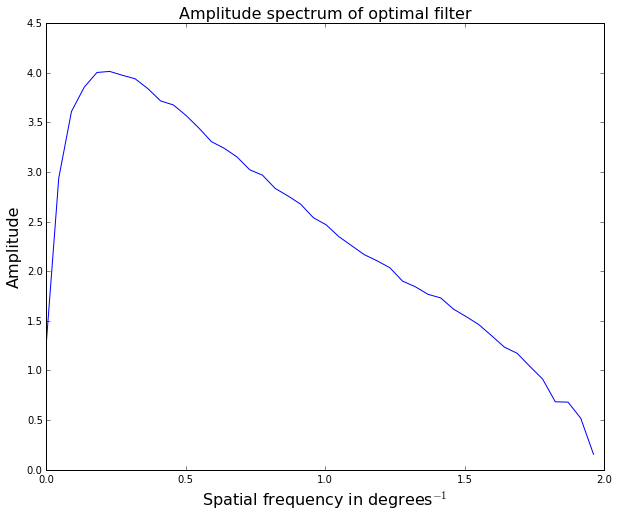

In [178]:
plot(originalFreqs,filt)
title('Amplitude spectrum of optimal filter',fontsize=16)
xlabel('Spatial frequency in degrees' + r'$^{-1}$',fontsize=16)
ylabel('Amplitude',fontsize=16)

In [179]:
filtF = filt[~np.isnan(filt)] #[complex(f) for f in filt if ~isnan(f)]
filtF = [complex(f) for f in filtF]
mask  = (1-isnan(filt))
freqF = np.where(mask.squeeze(), originalFreqs, nan)
freqF = freqF[~np.isnan(freqF)]

### Compute the inverse FFT

In [180]:
filtS = np.fft.ifftshift(np.fft.ifft(filtF))
# degsS = [d/pixelsToDeg for d in range(-len(filtS)/2,len(filtS)/2)]
# degsS = np.fft.fftfreq(len(filtS),spacing)

### Compute what the spatial domain scale should be

In [181]:
new_highest_freq = np.max(freqF)
new_spacing      = 1./(2*new_highest_freq)
degsS            = [i*new_spacing for i in xrange(-len(filtS)/2,len(filtS)/2)]

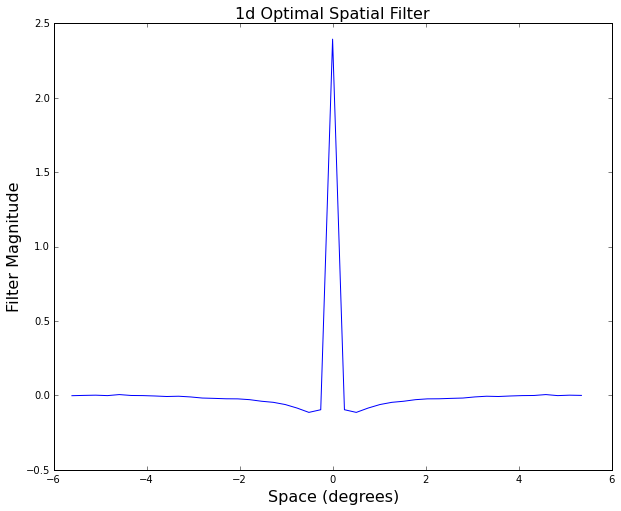

In [182]:
plot(degsS,filtS)
title('1d Optimal Spatial Filter',fontsize=16)
xlabel('Space (degrees)',fontsize=16)
ylabel('Filter Magnitude',fontsize=16)
#xlim([-.8,.8])

#### Zoomed in

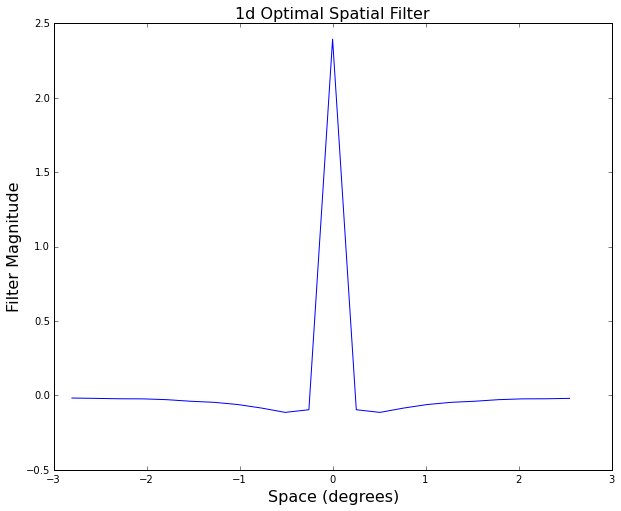

In [183]:
#plot(degsS[240:265],filtS[240:265])
# plot(degsS[100:135],filtS[100:135])
zoom     = 2
midpoint = len(degsS)/2
plot(degsS[midpoint-midpoint/zoom:midpoint+midpoint/zoom],filtS[midpoint-midpoint/zoom:midpoint+midpoint/zoom])
title('1d Optimal Spatial Filter',fontsize=16)
xlabel('Space (degrees)',fontsize=16)
ylabel('Filter Magnitude',fontsize=16)

# Incorporate realistic noise model

In [184]:
from scipy import interpolate

In [185]:
contrast = np.linspace(0,.40,10)
SNR = 15.1*contrast + 2.06
contrast2SNR = interpolate.interp1d(contrast, SNR)

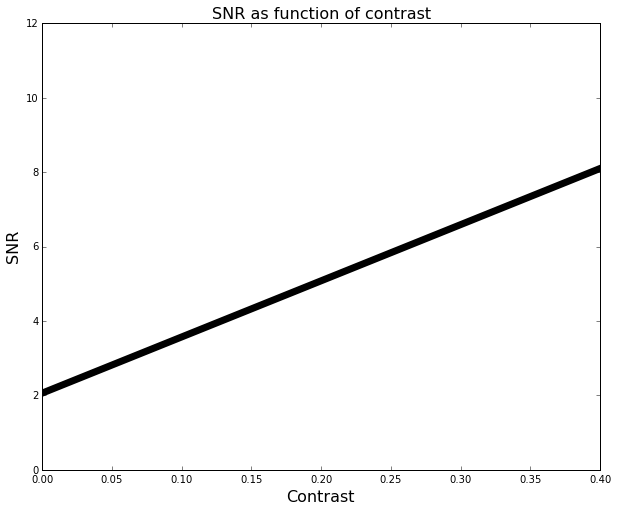

In [186]:
plot(contrast, SNR,'k',linewidth=7)
ylim([0,12])
xlim([0,.4])
title('SNR as function of contrast',fontsize=16)
xlabel('Contrast',fontsize=16)
ylabel('SNR',fontsize=16)

In [187]:
np.std(patches[1])

0.79728432081376543

In [188]:
np.mean(patches[1])

0.9999999999998378

In [189]:
effectiveContrasts = [np.std(p)/np.mean(p) for p in patches]

In [190]:
meanEffectiveContrast = np.mean(effectiveContrasts)

In [191]:
meanEffectiveContrast

0.58380008327353961

(array([ 14.,  39.,  13.,   8.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.13920678,  0.36273049,  0.58625419,  0.8097779 ,  1.03330161,
         1.25682532,  1.48034903,  1.70387274,  1.92739645,  2.15092016,
         2.37444387]),
 <a list of 10 Patch objects>)

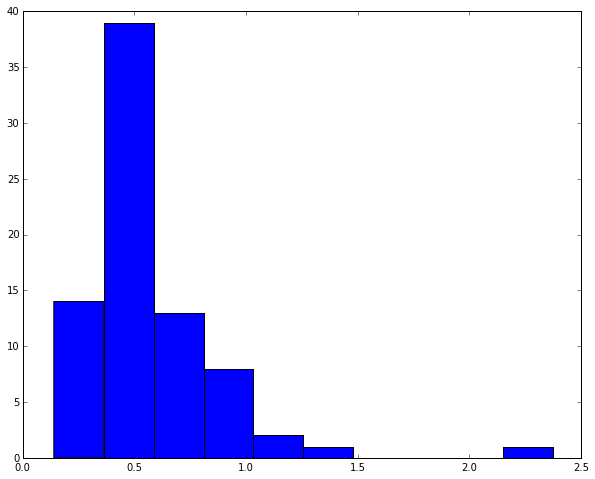

In [192]:
hist(effectiveContrasts)

### Effective contrast is very high, ~50%, so SNR = 8 or 10. This implies noise should be .1 std

## Select SNR from effective contrast of stimulus, 35%

In [193]:
stimulus_contrast = 0.35
# tol = 0.01
# whichContrast = np.argmax(np.where(abs(contrast-stimulus_contrast)<tol,contrast,0))

In [194]:
# effective_SNR = SNR[whichContrast]
effective_SNR = contrast2SNR(stimulus_contrast)
print 'The circuit SNR is %s.' %(effective_SNR)

The circuit SNR is 7.345.


In [195]:
# signal_variance = np.var(patches)
signal_variance = np.mean([np.var(p) for p in patches])
noise_variance  = signal_variance / effective_SNR
print 'The average signal variance is %s and the noise variance should be %s.' %(signal_variance, noise_variance)

The average signal variance is 0.432327115751 and the noise variance should be 0.0588600566032.


## By scaling the output noise by a factor $\alpha$, how does the ideal filter change?

In [196]:
expt = [uniqueSoln(originalSpectra, np.sqrt(noise_variance), i) for i in np.logspace(-3,1,10)]

The error from this choice of Lagrangian multiplier is 3.40208465304.
The error from this choice of Lagrangian multiplier is 3.40177544986.
The error from this choice of Lagrangian multiplier is 3.39938340552.
The error from this choice of Lagrangian multiplier is 3.38098194731.
The error from this choice of Lagrangian multiplier is 3.24528736437.
The error from this choice of Lagrangian multiplier is 2.48163026098.
The error from this choice of Lagrangian multiplier is 0.794692928346.
The error from this choice of Lagrangian multiplier is 1.33330441354e-07.
The error from this choice of Lagrangian multiplier is 6.09669391416e-07.
The error from this choice of Lagrangian multiplier is 5.71386318704e-07.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


In [197]:
expt_normalized = [e/np.max(e[~isnan(e)]) for e in expt]

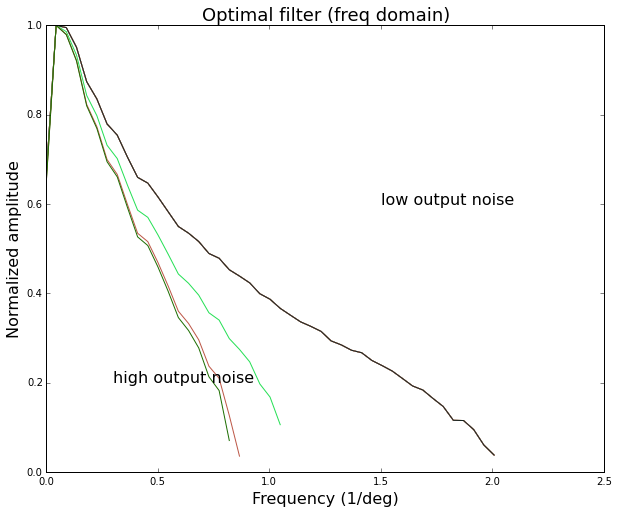

In [198]:
colors = np.random.rand(3,10)
for ide,e in enumerate(expt_normalized):
    plot(originalFreqs, e, c=colors[:,ide])

annotate('high output noise',(0.3,0.2),fontsize=16)
annotate('low output noise',(1.5,0.6),fontsize=16)
title('Optimal filter (freq domain)',fontsize=18)
xlabel('Frequency (1/deg)',fontsize=16)
ylabel('Normalized amplitude',fontsize=16)

### In addition to this shape change, there is a large effect where increasing noise stdev by $\alpha$ results in an output filter magnitude scaled by $1/\alpha$.

### How do the NaNs stack up as a function of output noise?

(15, 50)

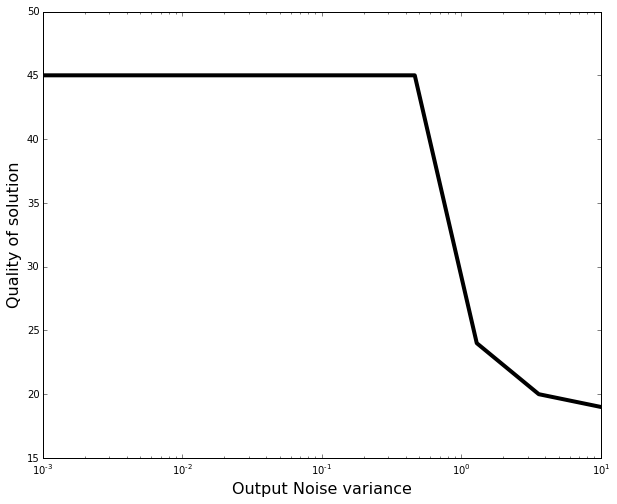

In [199]:
numNans = [sum(~isnan(expt_normalized[i])) for i in xrange(len(expt_normalized))]
plot(np.logspace(-3,1,10),numNans,'k',linewidth=4)
xlabel('Output Noise variance',fontsize=16)
ylabel('Quality of solution',fontsize=16)
xscale('log')
ylim([15,50])

## By scaling the input noise by a factor $\alpha$, how does the ideal filter change?

In [200]:
expt = [uniqueSoln(originalSpectra, i, np.sqrt(noise_variance)) for i in np.logspace(-3,1,10)]

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


The error from this choice of Lagrangian multiplier is 0.00066845497804.
The error from this choice of Lagrangian multiplier is 0.00140348341665.
The error from this choice of Lagrangian multiplier is 0.00014022842953.
The error from this choice of Lagrangian multiplier is 9.59236204352e-05.
The error from this choice of Lagrangian multiplier is 1.04431434131e-05.
The error from this choice of Lagrangian multiplier is 6.66056005905e-08.
The error from this choice of Lagrangian multiplier is 3.14402827569.
The error from this choice of Lagrangian multiplier is 3.39204647796.
The error from this choice of Lagrangian multiplier is 3.4019034837.
The error from this choice of Lagrangian multiplier is 3.4021265913.


In [201]:
noise_variance

0.058860056603208005

In [202]:
1./np.logspace(-3,1,10)[8]

0.27825594022071259

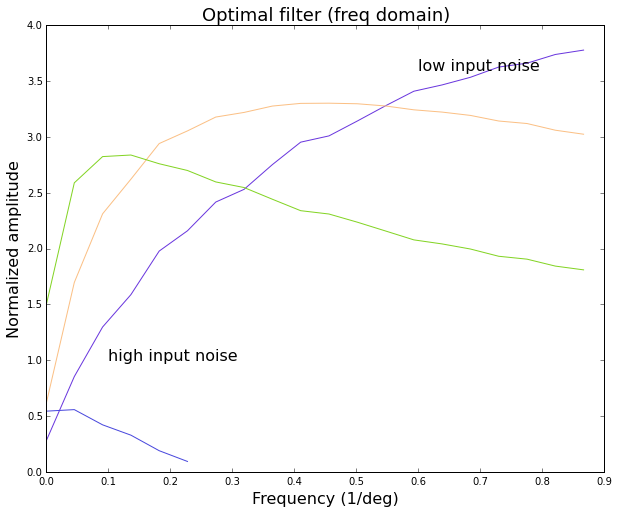

In [203]:
colors = np.random.rand(3,10)
zoom=20
for ide,e in enumerate(expt):
    plot(originalFreqs[:zoom], e[:zoom], c=colors[:,ide])
#plot(ama_freqs[:zoom], 3.2*(1-one_sided_ama_proj_fft)[:zoom], 'c--', linewidth=3)
    
annotate('high input noise',(0.1,1.0),fontsize=16)
annotate('low input noise',(0.6,3.6),fontsize=16)
title('Optimal filter (freq domain)',fontsize=18)
xlabel('Frequency (1/deg)',fontsize=16)
ylabel('Normalized amplitude',fontsize=16)

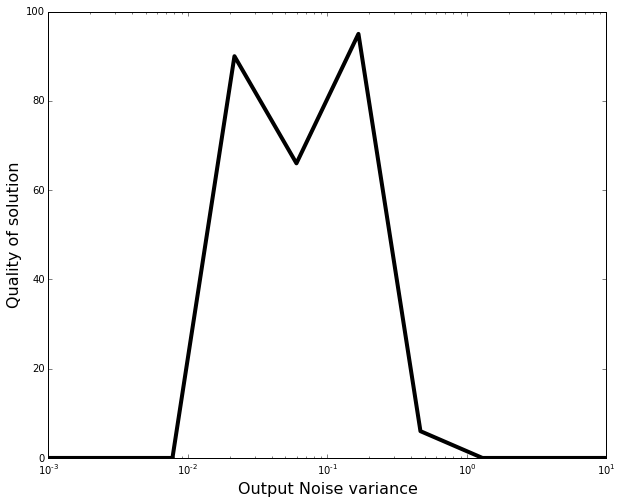

In [204]:
numNans = [sum(~isnan(expt[i])) for i in xrange(len(expt))]
plot(np.logspace(-3,1,10),numNans,'k',linewidth=4)
xlabel('Output Noise variance',fontsize=16)
ylabel('Quality of solution',fontsize=16)
xscale('log')

## Get ideal solution using this effective SNR

In [205]:
filt = uniqueSoln(originalSpectra, np.sqrt(noise_variance), 0.0001)

The error from this choice of Lagrangian multiplier is 3.40213005735.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


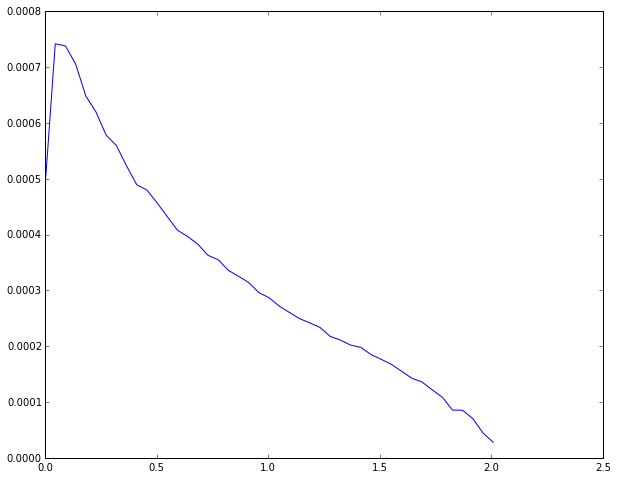

In [206]:
plot(originalFreqs, filt)

# Import David's original receptive field data

Sorry I wasn't able to concatenate all of the files into one matrix. For the ganglion cells the temporal dimension has a delta of 0.005s, while the interneurons have a temporal dimension of 0.01s. All but one of the cells (ganglion and interneuron) have a spatial delta of 0.027mm, the only one that is different is the second horizontal cell which has a spatial delta of 0.022mm.


allGC.txt is space x number x time  
H1A2.txt is time x space x number (first number dimension is a horizontal the last two are amacrine)  
H2.txt is time x space

In [209]:
data_path = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Surround size project/david_receptive_fields'

## Ganglion cells

In [210]:
file_name = data_path + '/allGC.txt'
data_gc   = np.loadtxt(file_name, delimiter="\t")

In [211]:
shape(data_gc)

(8000, 28)

In [212]:
data_gc_reshaped = data_gc.reshape((100,80,28))

<matplotlib.colorbar.Colorbar instance at 0x1172bd9e0>

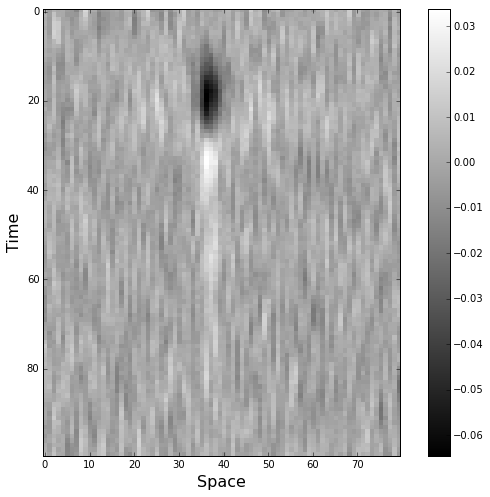

In [213]:
numGCells = 28

imshow(data_gc_reshaped[:,:,0])
xlabel('Space',fontsize=16)
ylabel('Time',fontsize=16)
colorbar()

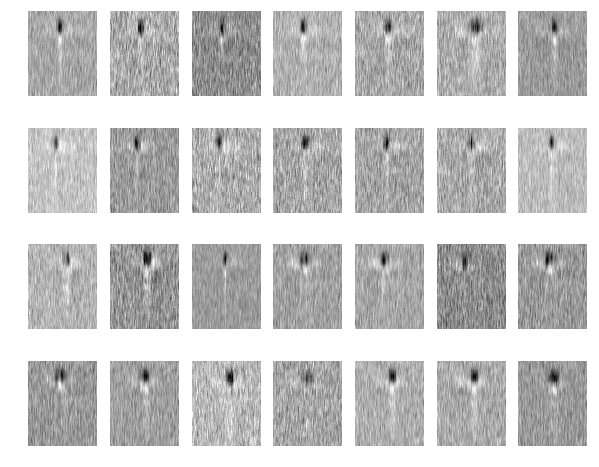

In [214]:
# Visualize the ganglion cell RFs.
num_cols = 7
num_rows = 4
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        subplot(num_rows, num_cols, plt_idx)
        imshow(data_gc_reshaped[:,:,plt_idx-1])
        pyplot.axis('off')
#         if i == 0:
#             plt.title(cls)


## Horizontal and Amacrine cells

In [215]:
file_name = data_path + '/H1A2.txt'
data_ha   = np.loadtxt(file_name, delimiter="\t")

In [216]:
shape(data_ha)

(150, 80)

In [217]:
data_ha_reshaped = data_ha.reshape((3,50,80))

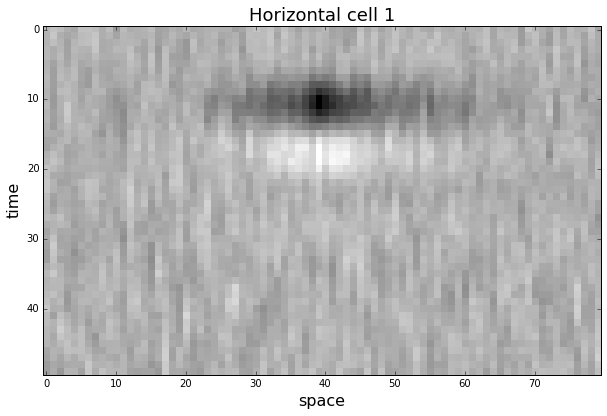

In [218]:
imshow(data_ha_reshaped[0,:,:])
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Horizontal cell 1',fontsize=18)
#colorbar()

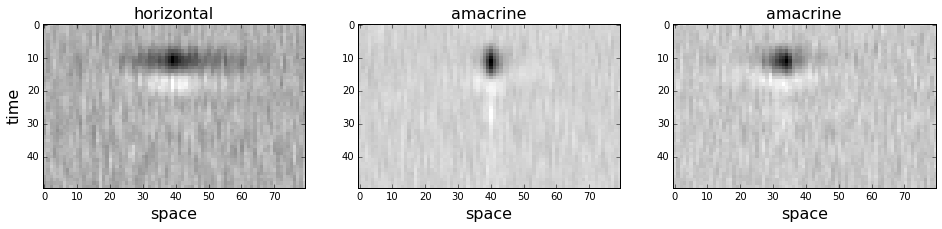

In [219]:
# Visualize the ganglion cell RFs.
classes = ['horizontal','amacrine','amacrine']
num_cols = 3
num_rows = 1
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_idx = i * num_cols + y + 1
        subplot(num_rows, num_cols, plt_idx)
        imshow(data_ha_reshaped[plt_idx-1,:,:])
        #plt.axis('off')
        
        if i == 0:
            title(classes[y],fontsize=16)
            xlabel('space',fontsize=16)
        if y == 0:
            ylabel('time',fontsize=16)
            
fig = gcf()
fig.set_size_inches((16,8))

## Get last horizontal cell

In [220]:
file_name = data_path + '/H2.txt'
data_h2   = np.loadtxt(file_name, delimiter="\t")
spacingH2 = 0.022 # mm

In [221]:
shape(data_h2)

(50, 100)

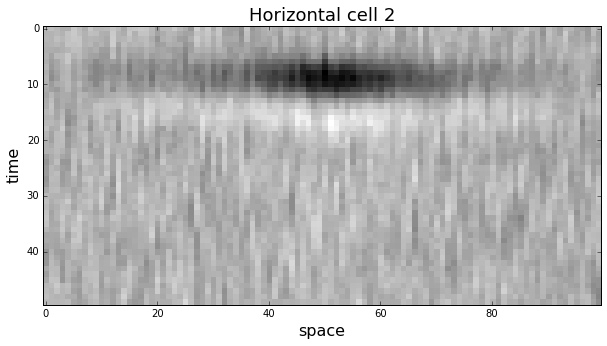

In [222]:
imshow(data_h2)
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Horizontal cell 2',fontsize=18)

## Get bipolar cell

In [223]:
micronsPerDeg = 50.

file_name = data_path + '/B1.txt'
data_b1   = np.loadtxt(file_name, delimiter="\t")
file_name = data_path + '/B2.txt'
data_b2   = np.loadtxt(file_name, delimiter="\t")
spacingB1 = 1000*0.022 # mm to microns
spacingB2 = 1000*0.022 # mm to microns
spaceB1   = [i*spacingB1 for i in np.linspace(-data_b1.shape[1]/2, data_b1.shape[1]/2,data_b1.shape[1])]
spaceB2   = [i*spacingB2 for i in np.linspace(-data_b2.shape[1]/2, data_b2.shape[1]/2,data_b2.shape[1])]
spaceB1   = array(spaceB1)/micronsPerDeg # degrees
spaceB2   = array(spaceB2)/micronsPerDeg # degrees
FsB1      = spaceB1[1]-spaceB1[0]
FsB2      = spaceB2[1]-spaceB2[0]

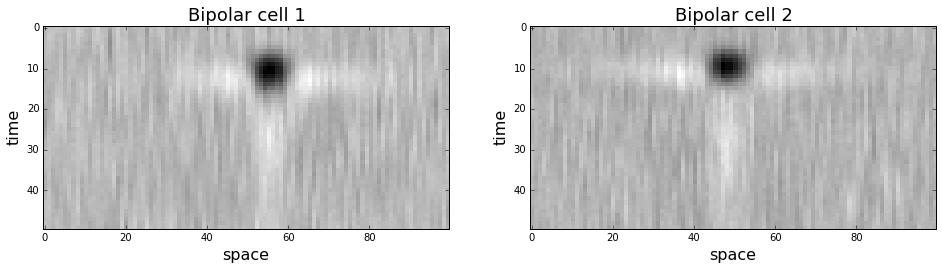

In [224]:
fig = gcf()
fig.set_size_inches((16,4))
subplot(1,2,1)
imshow(data_b1) #, extent=(spaceB1[0],spaceB1[-1],0,40))
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Bipolar cell 1',fontsize=18)

subplot(1,2,2)
imshow(data_b2)
xlabel('space',fontsize=16)
ylabel('time',fontsize=16)
title('Bipolar cell 2',fontsize=18)

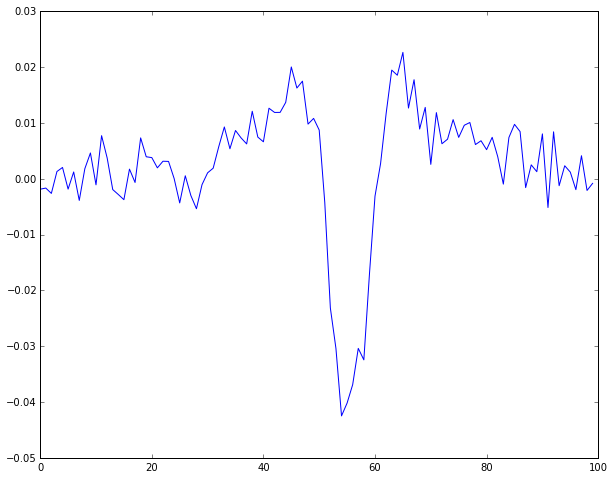

In [225]:
plot(data_b1[14,:])

In [226]:
pca_b1 = PCA(n_components=2)
pca_b1.fit(data_b1)

PCA(copy=True, n_components=2, whiten=False)

In [227]:
pca_b2 = PCA(n_components=2)
pca_b2.fit(data_b2[13:,:])

PCA(copy=True, n_components=2, whiten=False)

In [228]:
print pca_b1.explained_variance_ratio_

[ 0.78233735  0.07530592]


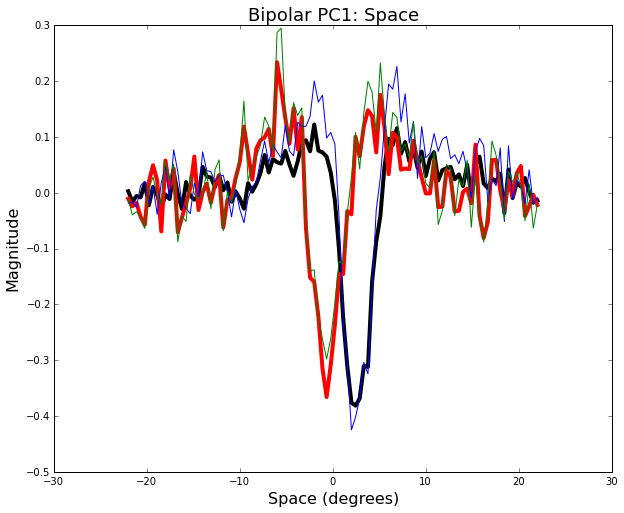

In [229]:
plot(spaceB1,pca_b1.components_[0],'k',linewidth=4)
plot(spaceB2, -pca_b2.components_[0],'r',linewidth=4)
plot(spaceB1, 10*data_b1[14,:])
plot(spaceB2, 15*data_b2[14,:])
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('Bipolar PC1: Space',fontsize=18)

# Ganglion cell

## These are noisy. Use PCA

In [230]:
pca = PCA(n_components=2)
pca.fit(data_gc_reshaped[:,:,0])

PCA(copy=True, n_components=2, whiten=False)

In [231]:
print pca.explained_variance_ratio_

[ 0.48194427  0.06614812]


In [232]:
spatialDelta = 0.027 # mm
space = np.linspace(-spatialDelta*data_gc_reshaped.shape[1]/2,spatialDelta*data_gc_reshaped.shape[1]/2,data_gc_reshaped.shape[1])
space = space*1000. # microns
space = space/micronsPerDeg # degrees
Fs    = space[1]-space[0]

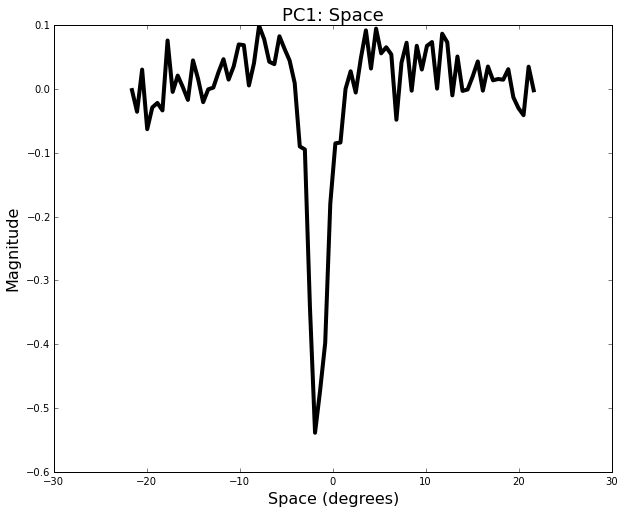

In [233]:
plot(space,pca.components_[0],'k',linewidth=4)
#plot(spaceB1, pca_b1.components_[0],'r',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [234]:
data_gc_reshaped.shape

(100, 80, 28)

In [235]:
pca.components_[0].shape

(80,)

In [236]:
pca_gcs = np.zeros((data_gc_reshaped.shape[2], data_gc_reshaped.shape[1]))
for g in range(data_gc_reshaped.shape[2]):
    pca = PCA(n_components=1)
    pca.fit(data_gc_reshaped[:,:,g])
    if np.max(pca.components_[0]) > 0.3:
        sgn = -1
    else:
        sgn = 1
    pca_gcs[g,:] = sgn*pca.components_[0]

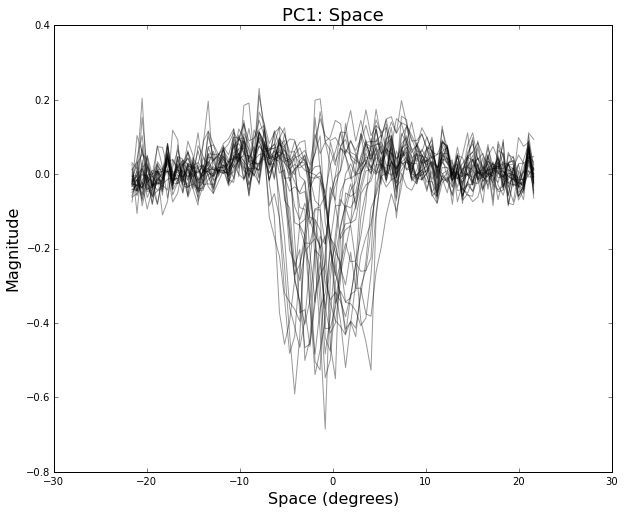

In [237]:
plot(space,pca_gcs.T,'k',linewidth=1, alpha=.4)
#plot(spaceB1, pca_b1.components_[0],'r',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [238]:
Fs

0.54683544303797404

In [239]:
ganglion_pca = pca.components_[0]

In [240]:
(sum(ganglion_pca), np.var(ganglion_pca), abs(np.max(ganglion_pca) - np.min(ganglion_pca)))

(-3.3203721474052994, 0.010777363875427357, 0.44702332413345752)

## How large is the center relative to the range?

In [241]:
abs(sum(ganglion_pca)/abs(np.max(ganglion_pca) - np.min(ganglion_pca)))

7.4277380354632498

In [242]:
exptFilterF = abs(fftshift(fft(pca.components_[0])))
#exptFreqsFwd = [i*Fs/len(exptFilterF) for i in range(len(exptFilterF)/2)]
#exptFreqsRwd = [-a for a in exptFreqsFwd[::-1]]
#exptFreqs    = exptFreqsRwd + exptFreqsFwd
exptFreqs = np.fft.fftshift(np.fft.fftfreq(len(exptFilterF),Fs))

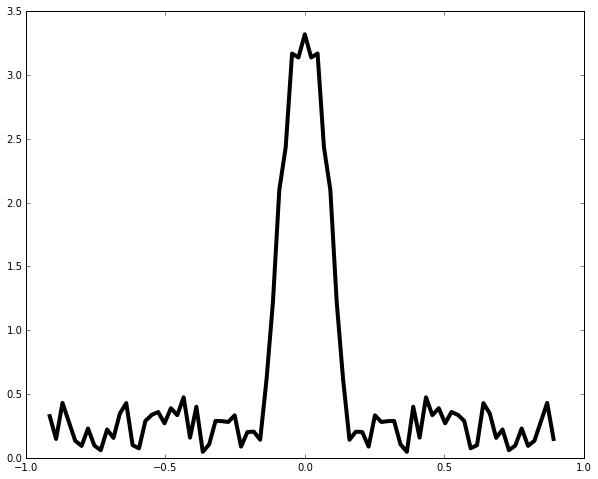

In [243]:
plot(exptFreqs,exptFilterF,'k',linewidth=4)

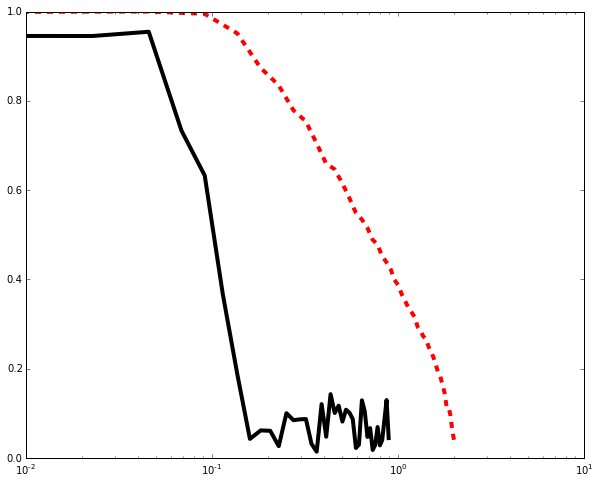

In [244]:
# get one sided fft
exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]
exptFilterFwd = exptFilterF[len(exptFilterF)/2:]

# normalize both experimental and ideal filter
exptFilterNorm = exptFilterFwd/np.max(exptFilterFwd)
idealFilterNorm = filt/np.max(filt[~isnan(filt)])

plot(exptFreqsFwd, exptFilterNorm, 'k', linewidth=4)
plot(originalFreqs, idealFilterNorm, 'r--', linewidth=4)

xscale('log')

## How well can we fit this with an ideal soln for any input or output noise??

In [245]:
np.sqrt(noise_variance)

0.24261091608418614

In [246]:
noise_variance

0.058860056603208005

In [247]:
fitFilt = uniqueSoln(originalSpectra, np.sqrt(noise_variance), 10e-4)

The error from this choice of Lagrangian multiplier is 3.40208465304.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


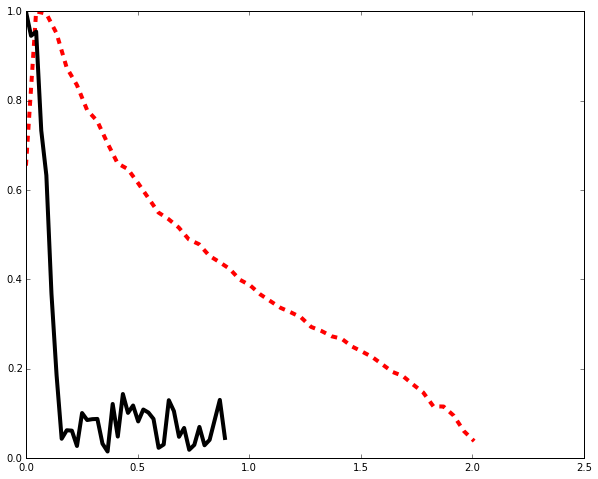

In [248]:
plot(originalFreqs, fitFilt/np.max(fitFilt[~isnan(fitFilt)]), 'r--', linewidth=4)
plot(exptFreqsFwd, exptFilterNorm, 'k', linewidth=4)

## What do the spatial RFs look like on the same plot?

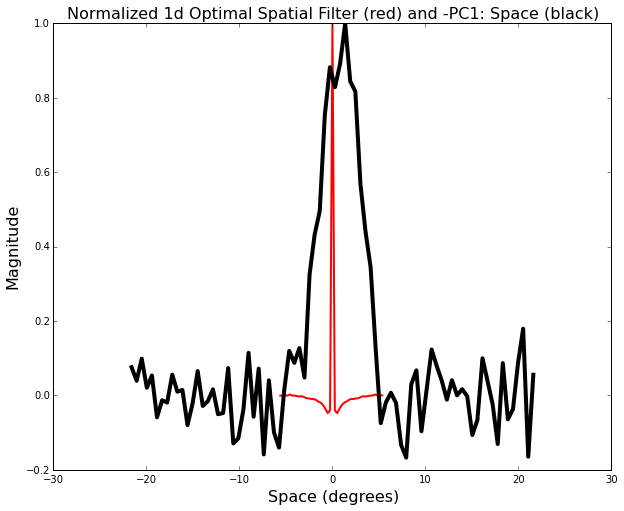

In [249]:
plot(degsS,filtS/np.max(filtS),'r',linewidth=2)
plot(space,pca.components_[0]/np.min(pca.components_[0]),'k',linewidth=4)
title('Normalized 1d Optimal Spatial Filter (red) and -PC1: Space (black)',fontsize=16)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
#xlim([-.8,.8])

In [250]:
gc_freqs = exptFreqsFwd
gc_amp   = exptFilterFwd

# Horizontal cell

## Look at a 1d spatial PCA component of 1st horizontal cell

In [251]:
pca = PCA(n_components=2)
pca.fit(data_ha_reshaped[0,:,:])

PCA(copy=True, n_components=2, whiten=False)

In [252]:
print pca.explained_variance_ratio_

[ 0.74921812  0.04016211]


In [253]:
spatialDelta = 0.027 # mm
micronsPerDeg = 50.
space_h1 = np.linspace(-spatialDelta*data_ha_reshaped.shape[2]/2,spatialDelta*data_ha_reshaped.shape[2]/2,data_ha_reshaped.shape[2])
space_h1 = space_h1*1000. # microns
space_h1 = space_h1/micronsPerDeg # degrees
Fs    = space_h1[1]-space_h1[0]

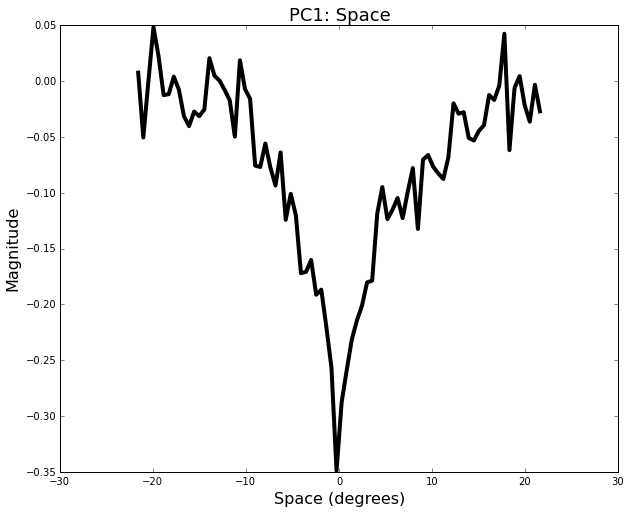

In [254]:
plot(space,pca.components_[0],'k',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [255]:
horz_pca = pca.components_[0]
pca_h1 = pca.components_[0]

In [256]:
exptFilterF = abs(fftshift(fft(pca.components_[0])))
# exptFreqsFwd = [i*Fs/len(exptFilterF) for i in range(len(exptFilterF)/2)]
# exptFreqsRwd = [-a for a in exptFreqsFwd[::-1]]
# exptFreqs    = exptFreqsRwd + exptFreqsFwd

exptFreqs = np.fft.fftshift(np.fft.fftfreq(len(exptFilterF),Fs))
exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]

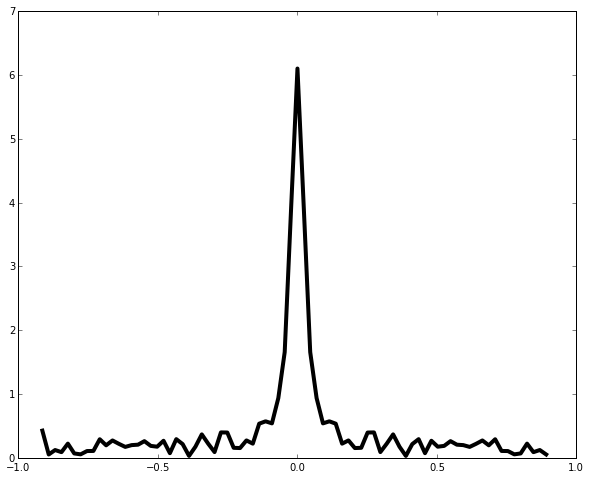

In [257]:
plot(exptFreqs,exptFilterF,'k',linewidth=4)

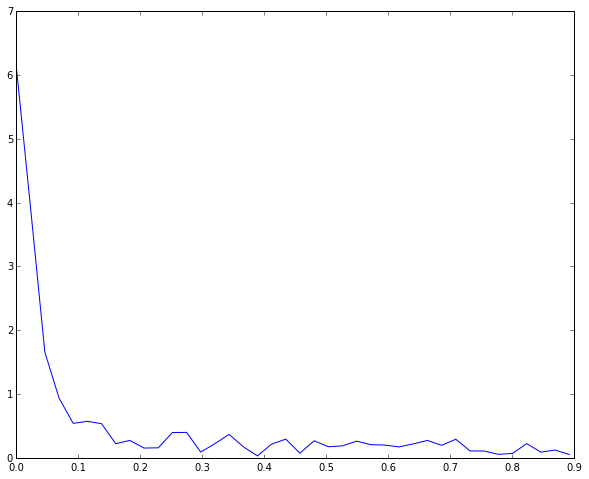

In [258]:
plot(exptFreqsFwd,exptFilterF[len(exptFilterF)/2:])

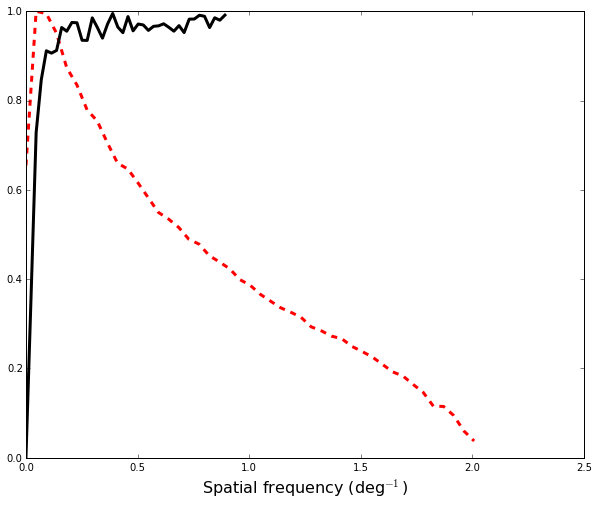

In [259]:
# get one sided fft
exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]
exptFilterFwd = exptFilterF[len(exptFilterF)/2:]

# normalize both experimental and ideal filter
exptFilterNorm = exptFilterFwd/np.max(exptFilterFwd)
# idealFilterNorm = filt/np.max(filt[~isnan(filt)])

plot(originalFreqs, idealFilterNorm, 'r--', linewidth=3) #[15.*a for a in idealFreqsFwd]
plot(exptFreqsFwd, 1-exptFilterNorm, 'k', linewidth=3)
xlabel('Spatial frequency (deg' + r'$^{-1}$' +')',fontsize=16)

In [260]:
horz_freqs = exptFreqsFwd
horz_amp   = exptFilterFwd

# 2nd Horizontal cell

In [261]:
pca = PCA(n_components=2)
pca.fit(data_h2)

PCA(copy=True, n_components=2, whiten=False)

In [262]:
print pca.explained_variance_ratio_

[ 0.77943321  0.04176094]


In [263]:
data_h2.shape

(50, 100)

In [264]:
micronsPerDeg = 50.
space_h2 = np.linspace(-spacingH2*data_h2.shape[1]/2,spacingH2*data_h2.shape[1]/2,data_h2.shape[1])
space_h2 = space_h2*1000. # microns
space_h2 = space_h2/micronsPerDeg # degrees
Fs    = space_h2[1]-space_h2[0]

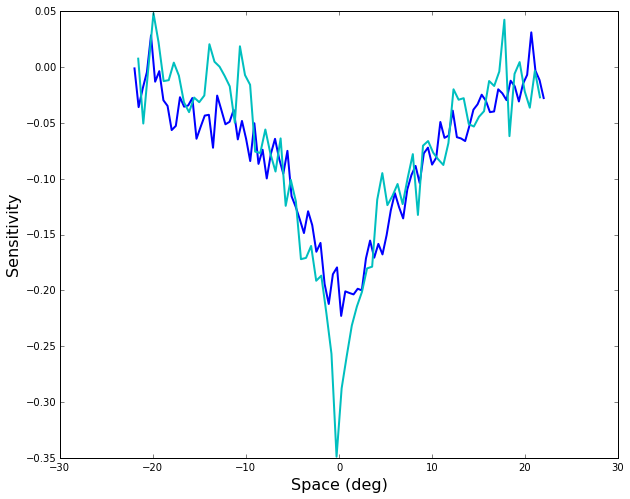

In [265]:
pca_h2 = pca.components_[0]
plot(space_h2, pca_h2, 'b', linewidth=2)
plot(space_h1, pca_h1, 'c', linewidth=2)
xlabel('Space (deg)', fontsize=16)
ylabel('Sensitivity', fontsize=16)

### Generate horizontal cell average, and error bars

<Container object of 3 artists>

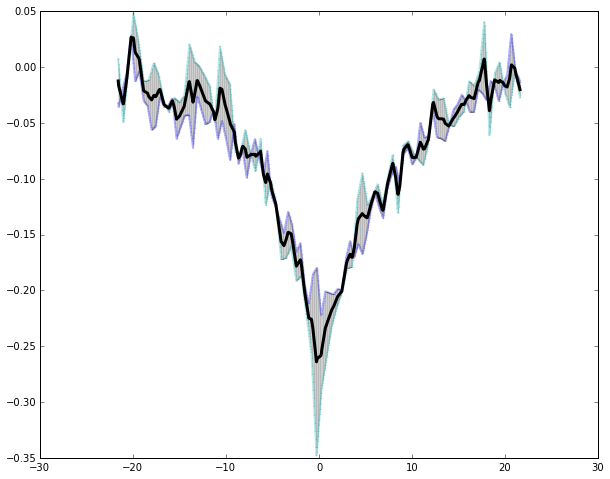

In [266]:
nPoints    = 1000
range_horz = [np.max([np.min(space_h1), np.min(space_h2)]), np.min([np.max(space_h1), np.max(space_h2)])]
space_horz = np.linspace(range_horz[0], range_horz[1], nPoints)
interp_h1  = interp1d(space_h1, pca_h1, kind='linear')
interp_h2  = interp1d(space_h2, pca_h2, kind='linear')
common_h1  = interp_h1(space_horz)
common_h2  = interp_h2(space_horz)
plot(space_horz, common_h1, 'c', linewidth=2, alpha=0.3)
plot(space_horz, common_h2, 'b', linewidth=2, alpha=0.3)
plot(space_horz, np.mean(np.vstack([common_h1, common_h2]), axis=0), 'k', linewidth=3)
errorbar(space_horz, np.mean(np.vstack([common_h1, common_h2]), axis=0), yerr=sem(np.vstack([common_h1, common_h2])), fmt='none', ecolor='k', capsize=1, capthick=1, alpha=0.1)

# Amacrine cell

In [267]:
pca = PCA(n_components=2)
pca.fit(data_ha_reshaped[1,:,:])

PCA(copy=True, n_components=2, whiten=False)

In [268]:
print pca.explained_variance_ratio_

[ 0.79972496  0.04208702]


In [269]:
spatialDelta = 0.027 # mm
micronsPerDeg = 50.
space = np.linspace(-spatialDelta*data_ha_reshaped.shape[2]/2,spatialDelta*data_ha_reshaped.shape[2]/2,data_ha_reshaped.shape[2])
space = space*1000. # microns
space = space/micronsPerDeg # degrees
Fs    = space[1]-space[0]

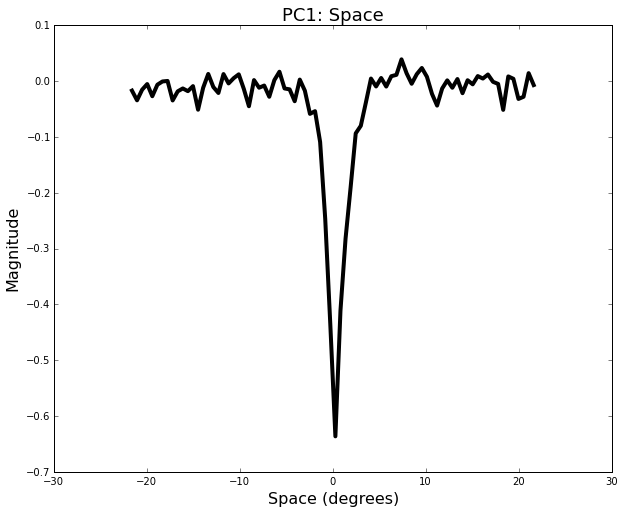

In [270]:
plot(space,pca.components_[0],'k',linewidth=4)
xlabel('Space (degrees)',fontsize=16)
ylabel('Magnitude',fontsize=16)
title('PC1: Space',fontsize=18)

In [271]:
ama_pca = pca.components_[0]

In [272]:
exptFilterF = abs(fftshift(fft(pca.components_[0])))
# exptFreqsFwd = [i*Fs/len(exptFilterF) for i in range(len(exptFilterF)/2)]
# exptFreqsRwd = [-a for a in exptFreqsFwd[::-1]]
# exptFreqs    = exptFreqsRwd + exptFreqsFwd

exptFreqs = np.fft.fftshift(np.fft.fftfreq(len(exptFilterF),Fs))
exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]

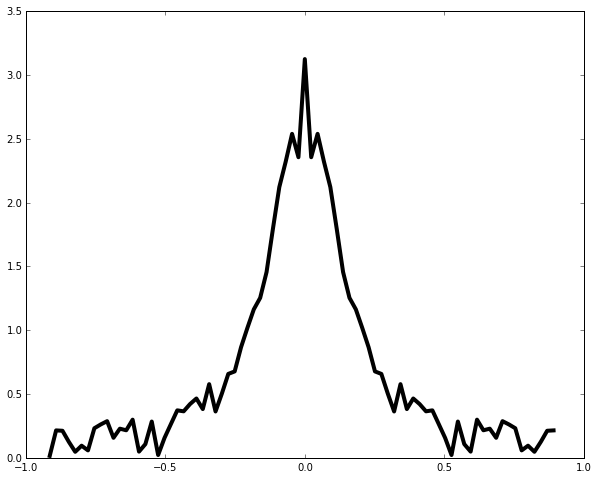

In [273]:
plot(exptFreqs,exptFilterF,'k',linewidth=4)

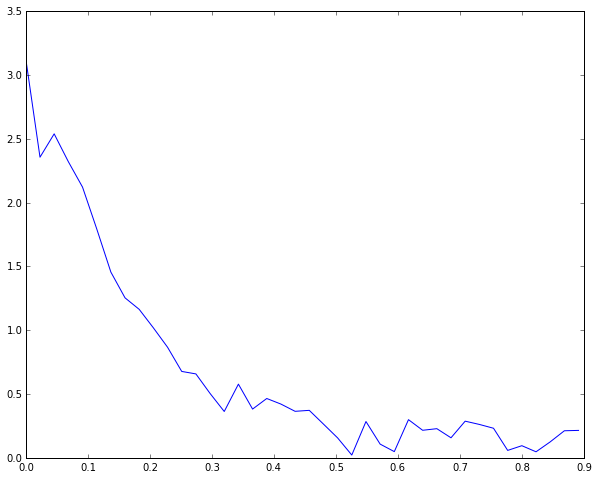

In [274]:
plot(exptFreqsFwd,exptFilterF[len(exptFilterF)/2:])

In [275]:
ama_freqs = exptFreqsFwd
ama_amp   = exptFilterFwd

## Get all amacrine cells

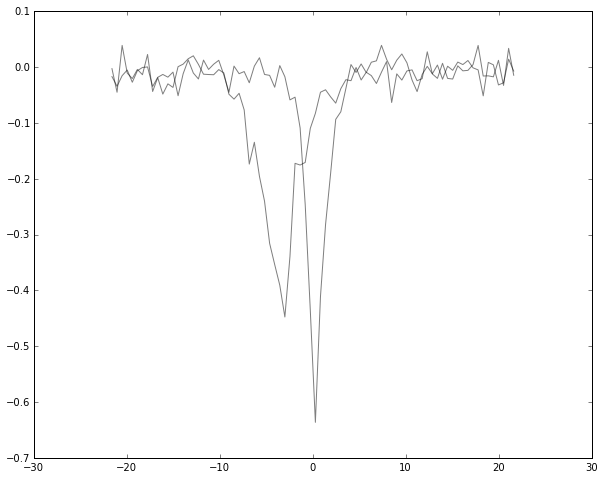

In [276]:
pca_amas = np.zeros((2, data_ha_reshaped.shape[2]))
for ama in range(pca_amas.shape[0]):
    pca = PCA(n_components=1)
    pca.fit(data_ha_reshaped[ama+1,:,:])
    pca_amas[ama] = pca.components_[0]
    
plot(space, pca_amas.T, 'k', linewidth=1, alpha=0.5)


In [277]:
ama_amp /= np.max(ama_amp)
#gc_amp  /= np.max(gc_amp)
horz_amp /= np.max(horz_amp)

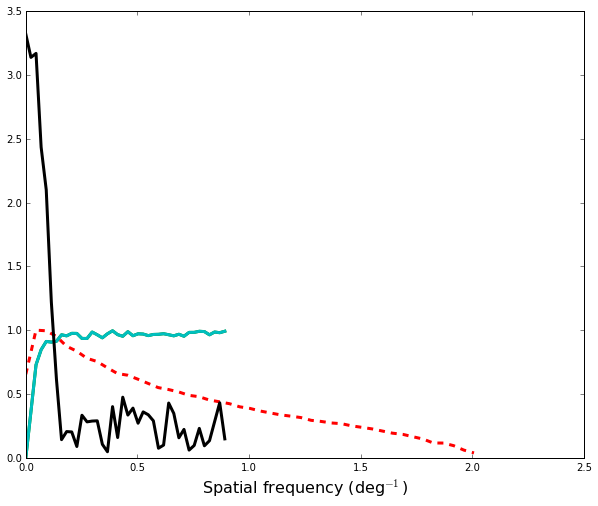

In [278]:
# # get one sided fft
# exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]
# exptFilterFwd = exptFilterF[len(exptFilterF)/2:]

# # normalize both experimental and ideal filter
# exptFilterNorm = exptFilterFwd/np.max(exptFilterFwd)
# # idealFilterNorm = filt/np.max(filt[~isnan(filt)])

zoom = 100

plot(originalFreqs[:zoom], idealFilterNorm[:zoom], 'r--', linewidth=3) #[15.*a for a in idealFreqsFwd]
plot(horz_freqs[:zoom], (1-horz_amp)[:zoom], 'g', linewidth=3)
plot(ama_freqs[:zoom], (1-ama_amp)[:zoom], 'c', linewidth=3)
plot(gc_freqs[:zoom], gc_amp[:zoom], 'k', linewidth=3)
xlabel('Spatial frequency (deg' + r'$^{-1}$' +')',fontsize=16)
#xscale('log')
#xlim([10e-3,10e1])

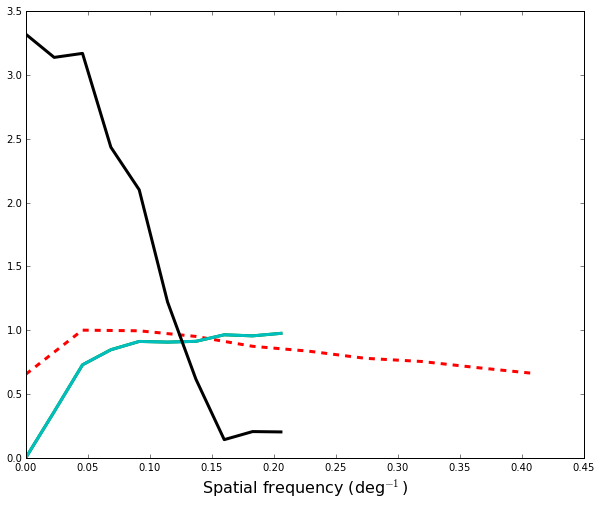

In [279]:
# # get one sided fft
# exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]
# exptFilterFwd = exptFilterF[len(exptFilterF)/2:]

# # normalize both experimental and ideal filter
# exptFilterNorm = exptFilterFwd/np.max(exptFilterFwd)
# # idealFilterNorm = filt/np.max(filt[~isnan(filt)])

zoom = 10

plot(originalFreqs[:zoom], idealFilterNorm[:zoom], 'r--', linewidth=3) #[15.*a for a in idealFreqsFwd]
plot(horz_freqs[:zoom], (1-horz_amp)[:zoom], 'g', linewidth=3)
plot(ama_freqs[:zoom], (1-ama_amp)[:zoom], 'c', linewidth=3)
plot(gc_freqs[:zoom], gc_amp[:zoom], 'k', linewidth=3)
xlabel('Spatial frequency (deg' + r'$^{-1}$' +')',fontsize=16)
#xscale('log')
#xlim([10e-3,10e1])

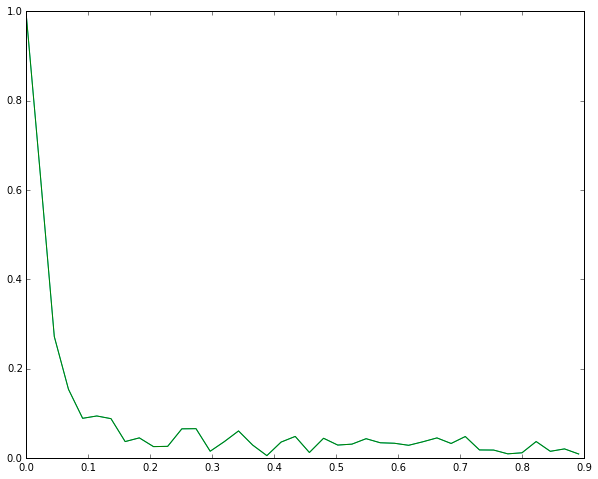

In [280]:
plot(ama_freqs, ama_amp,'c')
plot(horz_freqs, horz_amp,'g')

## Model projective fields

In [281]:
# amacrine projective field
x_dist    = np.linspace(0,500,11)
ama_proj  = [5*np.exp(-t/78) for t in np.linspace(0,500,11)]
horz_proj = [5*np.exp(-t/118) for t in np.linspace(0,500,11)]

In [282]:
micronsPerDeg

50.0

In [283]:
x_dist[1]-x_dist[0]

50.0

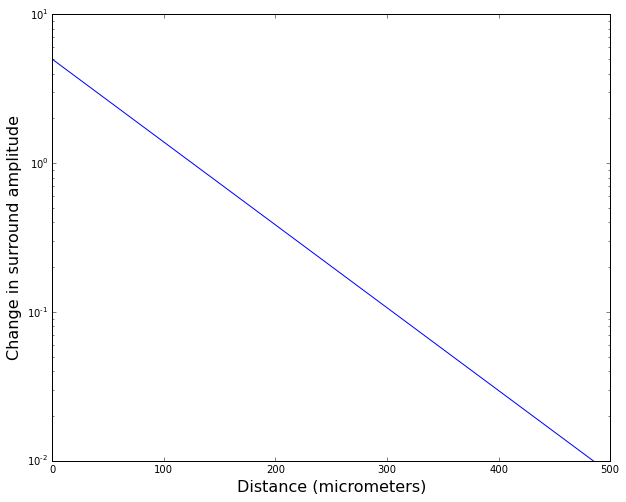

In [284]:
plot(x_dist, ama_proj)
yscale('log')
ylim([0.01, 10])
xlabel('Distance (micrometers)',fontsize=16)
ylabel('Change in surround amplitude',fontsize=16)

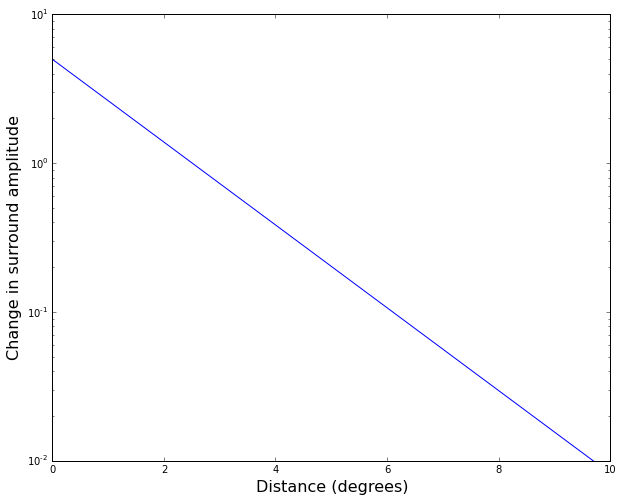

In [285]:
plot(x_dist/micronsPerDeg, ama_proj)
yscale('log')
ylim([0.01, 10])
xlabel('Distance (degrees)',fontsize=16)
ylabel('Change in surround amplitude',fontsize=16)

In [286]:
50./micronsPerDeg

1.0

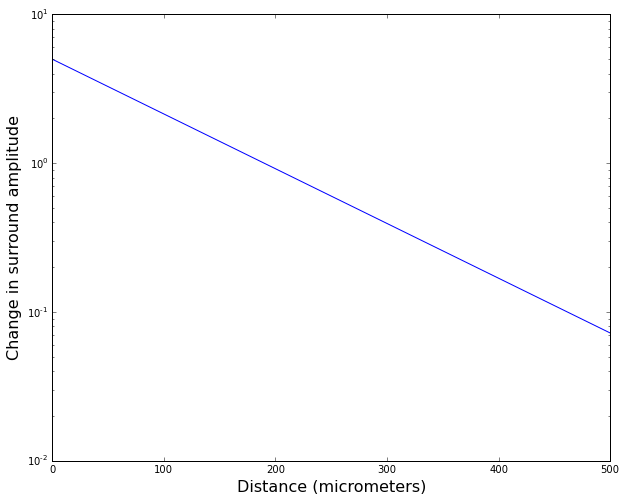

In [287]:
plot(x_dist, horz_proj)
yscale('log')
ylim([0.01, 10])
xlabel('Distance (micrometers)',fontsize=16)
ylabel('Change in surround amplitude',fontsize=16)

In [288]:
print 'Microns/deg for measured RF is %s, spacing for projective field measurement is %s.' %(micronsPerDeg,x_dist[1]-x_dist[0])

Microns/deg for measured RF is 50.0, spacing for projective field measurement is 50.0.


In [289]:
new_horz_proj = [exp(-abs(t)/(118/22)) for t in np.linspace(np.min(space),np.max(space),len(space))]

In [290]:
new_ama_proj = [exp(-abs(t)/(78/22)) for t in np.linspace(np.min(space),np.max(space),len(space))]

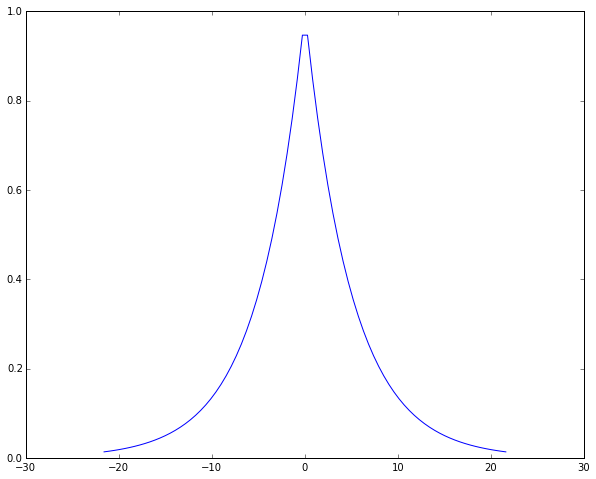

In [291]:
plot(np.linspace(np.min(space),np.max(space),len(space)), new_horz_proj)

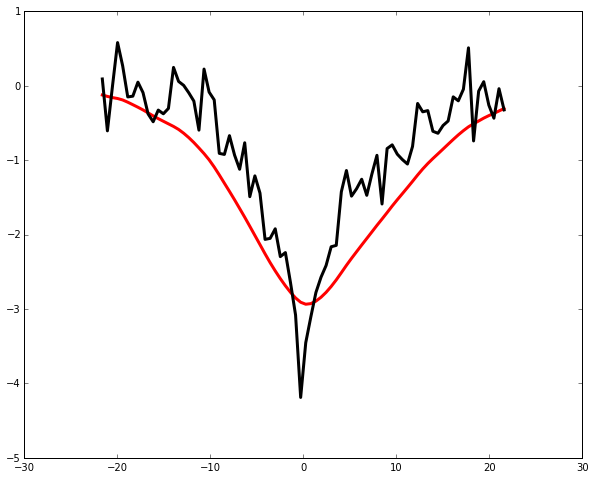

In [292]:
plot(space,np.convolve(new_horz_proj, horz_pca, mode='same'),'r',linewidth=3)
plot(space,12*horz_pca,'k',linewidth=3)

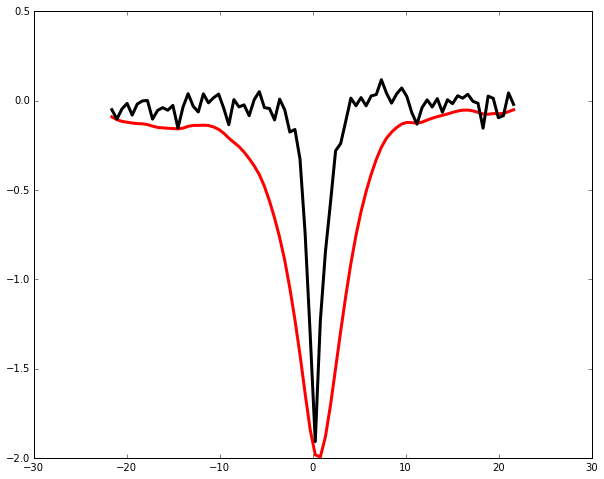

In [293]:
plot(space,np.convolve(new_ama_proj, ama_pca, mode='same'),'r',linewidth=3)
plot(space,3*ama_pca,'k',linewidth=3)

In [294]:
horz_rf_proj_new = np.convolve(new_horz_proj, horz_pca, mode='same')
horz_rf_proj_new /= abs(np.min(horz_rf_proj_new))

In [295]:
ama_rf_proj_new = np.convolve(new_ama_proj, ama_pca, mode='same')
ama_rf_proj_new /= abs(np.min(ama_rf_proj_new))

In [296]:
one_sided_horz_proj_fft = abs(fft(horz_rf_proj_new))[:len(horz_rf_proj_new)/2]
one_sided_horz_proj_fft /= np.max(one_sided_horz_proj_fft)

In [297]:
one_sided_ama_proj_fft = abs(fft(ama_rf_proj_new))[:len(ama_rf_proj_new)/2]
one_sided_ama_proj_fft /= np.max(one_sided_ama_proj_fft)

In [298]:
bipolar_fft = fftshift(abs(fft(pca_b1.components_[0])))[len(pca_b1.components_[0])/2:]
bipolar_fft /= np.max(bipolar_fft)
bipolarFreqs = np.fft.fftshift(np.fft.fftfreq(len(fft(pca_b1.components_[0])),Fs))
bipolarFreqsFwd = bipolarFreqs[len(bipolarFreqs)/2:]

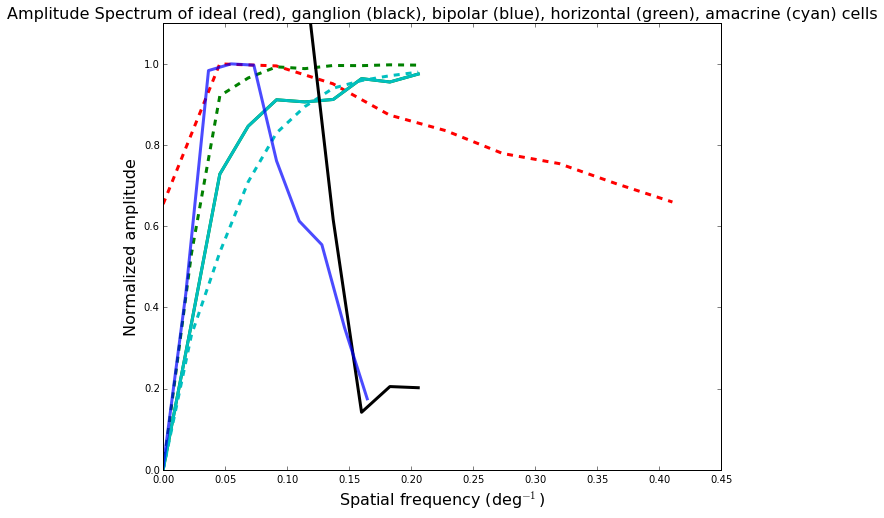

In [299]:
# # get one sided fft
# exptFreqsFwd = exptFreqs[len(exptFreqs)/2:]
# exptFilterFwd = exptFilterF[len(exptFilterF)/2:]

# # normalize both experimental and ideal filter
# exptFilterNorm = exptFilterFwd/np.max(exptFilterFwd)
# # idealFilterNorm = filt/np.max(filt[~isnan(filt)])

zoom = 10

plot(originalFreqs[:zoom], idealFilterNorm[:zoom], 'r--', linewidth=3) #[15.*a for a in idealFreqsFwd]
plot(horz_freqs[:zoom], (1-horz_amp)[:zoom], 'g', linewidth=3)
plot(horz_freqs[:zoom], (1-one_sided_horz_proj_fft)[:zoom], 'g--', linewidth=3)
plot(ama_freqs[:zoom], (1-ama_amp)[:zoom], 'c', linewidth=3)
plot(ama_freqs[:zoom], (1-one_sided_ama_proj_fft)[:zoom], 'c--', linewidth=3)
plot(gc_freqs[:zoom], gc_amp[:zoom], 'k', linewidth=3)
plot(bipolarFreqsFwd[:zoom], bipolar_fft[:zoom], 'b', linewidth=3, alpha=0.7)
xlabel('Spatial frequency (deg' + r'$^{-1}$' +')',fontsize=16)
#xscale('log')
#xlim([10e-3,10e1])
ylim([0,1.1])
ylabel('Normalized amplitude',fontsize=16)
title('Amplitude Spectrum of ideal (red), ganglion (black), bipolar (blue), horizontal (green), amacrine (cyan) cells', fontsize=16)

## Pablo's receptive fields

In [302]:
data_path = '/Users/lmcintosh/Documents/Stanford/00 Baccus Lab/Surround size project/pablo_receptive_fields'

In [303]:
file_name = data_path + '/bip1_2d_space.txt'
data_bip1 = np.loadtxt(file_name, delimiter="\t")

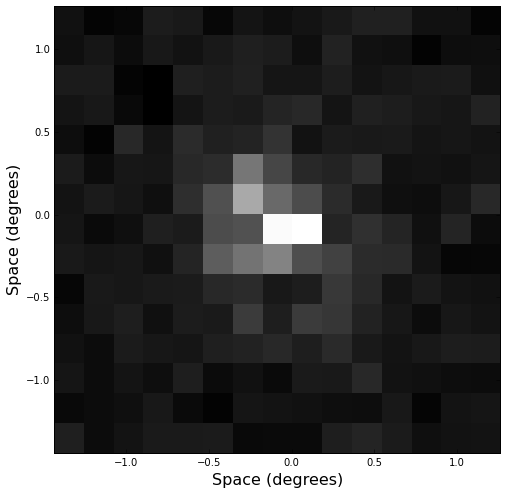

In [304]:
spacing_bip1 = 9 # microns
spacing_bip1 /= micronsPerDeg # convert to degrees
space_bip1 = [i*spacing_bip1 for i in np.linspace(-data_bip1.shape[0]/2, data_bip1.shape[0]/2, data_bip1.shape[0])]
imshow(data_bip1, extent=(space_bip1[0], space_bip1[-1], space_bip1[0], space_bip1[-1]))
xlabel('Space (degrees)',fontsize=16)
ylabel('Space (degrees)',fontsize=16)

In [305]:
frqRot_bip1, ampRot_bip1 = spectrum2d(data_bip1,Fs=1./(spacing_bip1),frequencyFlag=True)

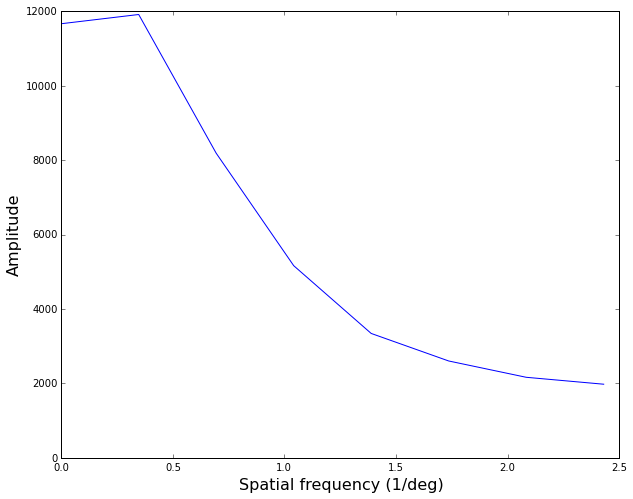

In [306]:
plot(frqRot_bip1, ampRot_bip1)
xlabel('Spatial frequency (1/deg)',fontsize=16)
ylabel('Amplitude',fontsize=16)

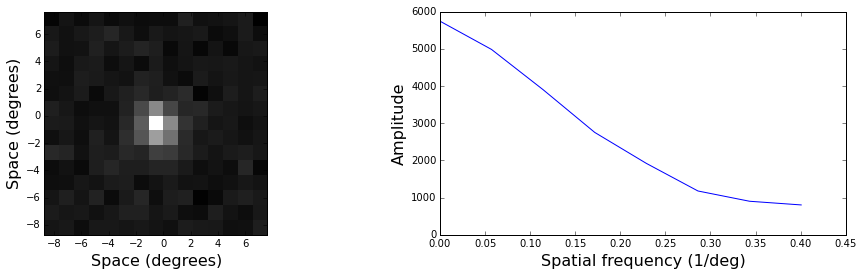

In [307]:
file_name = data_path + '/bip3_2d_space.txt'
data_bip3 = np.loadtxt(file_name, delimiter="\t")
spacing_bip3 = 54.6 # microns
spacing_bip3 /= micronsPerDeg # convert to degrees

fig = gcf()
fig.set_size_inches((16,4))
subplot(1,2,1)
space_bip3 = [i*spacing_bip3 for i in np.linspace(-data_bip3.shape[0]/2, data_bip3.shape[0]/2, data_bip3.shape[0])]
imshow(data_bip3, extent=(space_bip3[0], space_bip3[-1], space_bip3[0], space_bip3[-1]))
xlabel('Space (degrees)',fontsize=16)
ylabel('Space (degrees)',fontsize=16)

subplot(1,2,2)
frqRot_bip3, ampRot_bip3 = spectrum2d(data_bip3, Fs=1./(spacing_bip3), frequencyFlag=True)
plot(frqRot_bip3, ampRot_bip3)
xlabel('Spatial frequency (1/deg)',fontsize=16)
ylabel('Amplitude',fontsize=16)

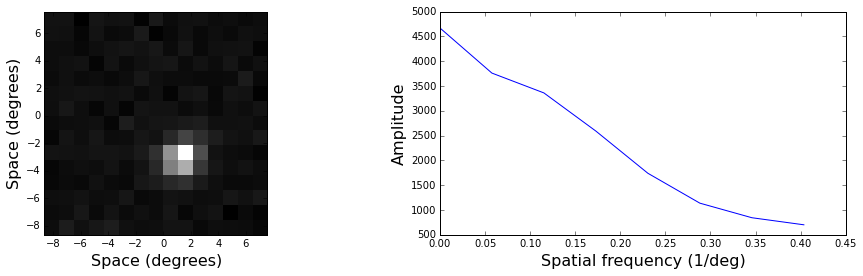

In [308]:
file_name = data_path + '/bip4_2d_space.txt'
data_bip4 = np.loadtxt(file_name, delimiter="\t")
spacing_bip4 = 54.2 # microns
spacing_bip4 /= micronsPerDeg # convert to degrees

fig = gcf()
fig.set_size_inches((16,4))
subplot(1,2,1)
space_bip4 = [i*spacing_bip4 for i in np.linspace(-data_bip4.shape[0]/2, data_bip4.shape[0]/2, data_bip4.shape[0])]
imshow(data_bip4, extent=(space_bip4[0], space_bip4[-1], space_bip4[0], space_bip4[-1]))
xlabel('Space (degrees)',fontsize=16)
ylabel('Space (degrees)',fontsize=16)

subplot(1,2,2)
frqRot_bip4, ampRot_bip4 = spectrum2d(data_bip4, Fs=1./(spacing_bip4), frequencyFlag=True)
plot(frqRot_bip4, ampRot_bip4)
xlabel('Spatial frequency (1/deg)',fontsize=16)
ylabel('Amplitude',fontsize=16)

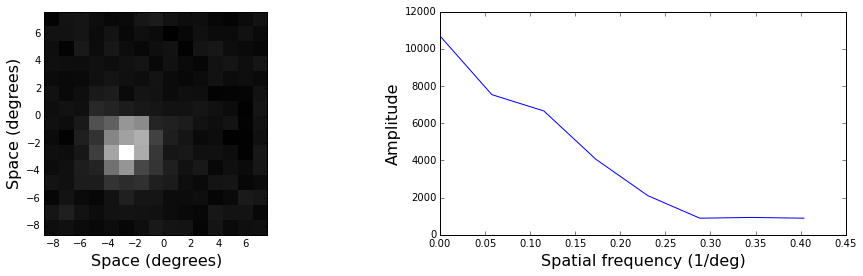

In [309]:
file_name = data_path + '/bip5_2d_space.txt'
data_bip5 = np.loadtxt(file_name, delimiter="\t")
spacing_bip5 = 54.2 # microns
spacing_bip5 /= micronsPerDeg # convert to degrees

fig = gcf()
fig.set_size_inches((16,4))
subplot(1,2,1)
space_bip5 = [i*spacing_bip5 for i in np.linspace(-data_bip5.shape[0]/2, data_bip5.shape[0]/2, data_bip5.shape[0])]
imshow(data_bip5, extent=(space_bip5[0], space_bip5[-1], space_bip5[0], space_bip5[-1]))
xlabel('Space (degrees)',fontsize=16)
ylabel('Space (degrees)',fontsize=16)

subplot(1,2,2)
frqRot_bip5, ampRot_bip5 = spectrum2d(data_bip5, Fs=1./(spacing_bip5), frequencyFlag=True)
plot(frqRot_bip5, ampRot_bip5)
xlabel('Spatial frequency (1/deg)',fontsize=16)
ylabel('Amplitude',fontsize=16)

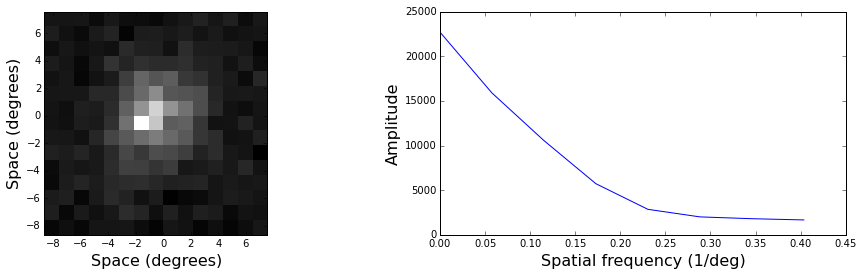

In [310]:
file_name = data_path + '/bip7_2d_space.txt'
data_bip7 = np.loadtxt(file_name, delimiter="\t")
spacing_bip7 = 54.2 # microns
spacing_bip7 /= micronsPerDeg # convert to degrees

fig = gcf()
fig.set_size_inches((16,4))
subplot(1,2,1)
space_bip7 = [i*spacing_bip7 for i in np.linspace(-data_bip7.shape[0]/2, data_bip7.shape[0]/2, data_bip7.shape[0])]
imshow(data_bip7, extent=(space_bip7[0], space_bip7[-1], space_bip7[0], space_bip7[-1]))
xlabel('Space (degrees)',fontsize=16)
ylabel('Space (degrees)',fontsize=16)

subplot(1,2,2)
frqRot_bip7, ampRot_bip7 = spectrum2d(data_bip7, Fs=1./(spacing_bip7), frequencyFlag=True)
plot(frqRot_bip7, ampRot_bip7)
xlabel('Spatial frequency (1/deg)',fontsize=16)
ylabel('Amplitude',fontsize=16)


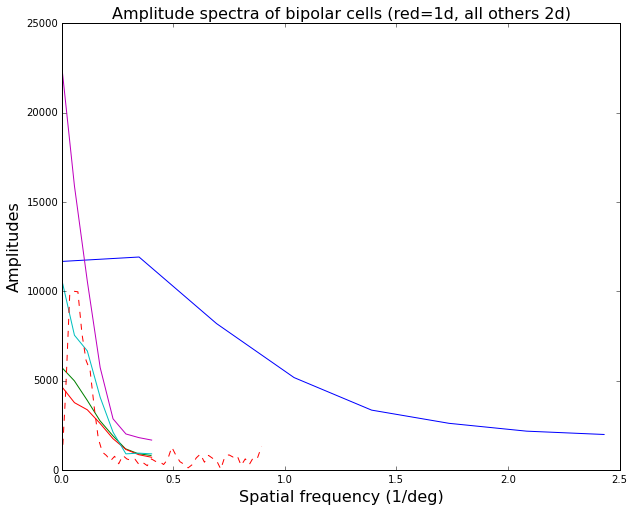

In [311]:
plot(frqRot_bip1, ampRot_bip1)
plot(frqRot_bip3, ampRot_bip3)
plot(frqRot_bip4, ampRot_bip4)
plot(frqRot_bip5, ampRot_bip5)
plot(frqRot_bip7, ampRot_bip7)
plot(bipolarFreqsFwd, 10000*bipolar_fft, 'r--')
xlabel('Spatial frequency (1/deg)',fontsize=16)
ylabel('Amplitudes',fontsize=16)
title('Amplitude spectra of bipolar cells (red=1d, all others 2d)', fontsize=16)

# Weight horizontal and amacrine cell surround with narrow surround

In [312]:
print 'The lengths of amacrine, %d, and horz., %d, projective fields should be the same.' %(len(ama_rf_proj_new),len(horz_rf_proj_new))

The lengths of amacrine, 80, and horz., 80, projective fields should be the same.


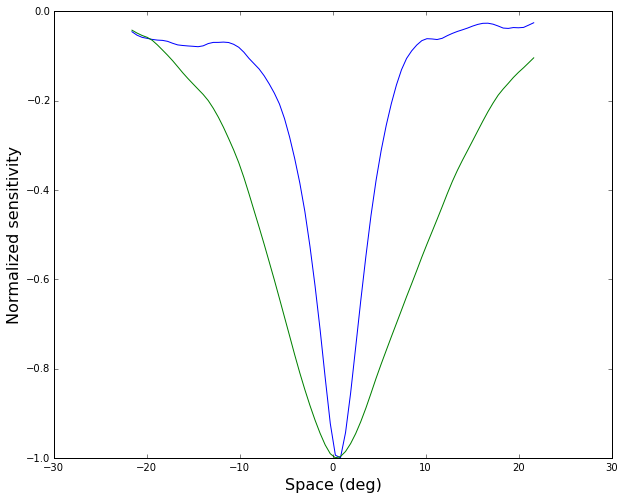

In [313]:
plot(space,ama_rf_proj_new)
plot(space,horz_rf_proj_new)
xlabel('Space (deg)', fontsize=16)
ylabel('Normalized sensitivity', fontsize=16)

## Specify surround weighting

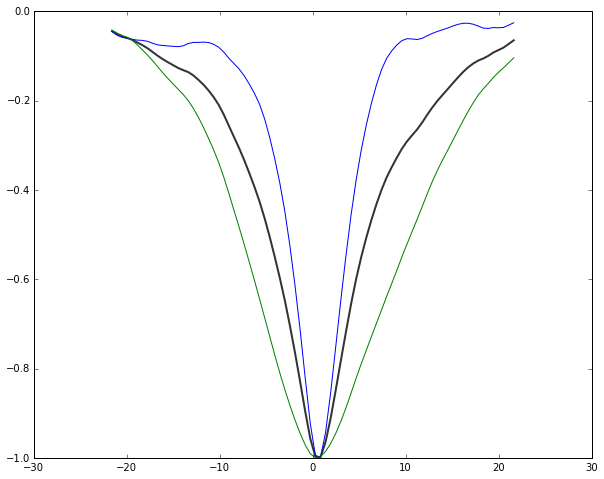

In [314]:
horz_weighting = 0.5
ama_weighting  = 0.5
surround       = horz_weighting * horz_rf_proj_new + ama_weighting * ama_rf_proj_new
plot(space, surround, 'k', linewidth=2, alpha=0.8)
plot(space,ama_rf_proj_new, 'b')
plot(space,horz_rf_proj_new, 'g')

## Specify center

In [315]:
#center           = center_weighting * np.where(surround==np.min(surround), 1, 0) # delta function
center           = gaussian(x=space, sigma=.25, mu=space[surround==np.min(surround)]) # gaussian

In [316]:
center_weighting = 2.1
surround_weighting = .1

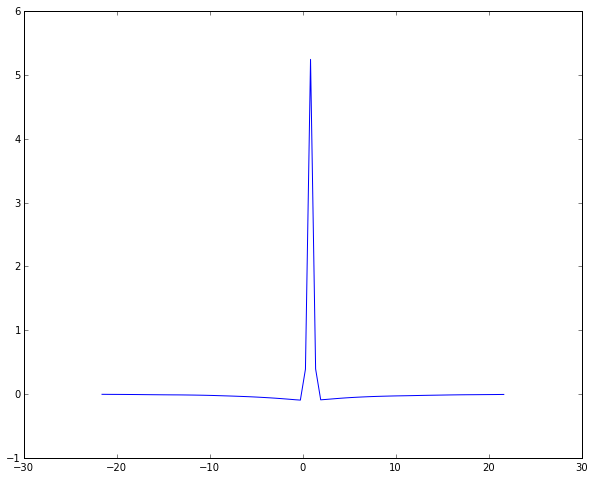

In [317]:
rf = center_weighting * center.squeeze() + surround_weighting * surround
plot(space, rf)

#### Compare properties to real ganglion cell

In [318]:
(np.sum(rf), abs(np.sum(rf)/(np.max(rf) - np.min(rf))))

(3.6607333805213087, 0.68513461919691321)

In [319]:
(np.sum(ganglion_pca), abs(sum(ganglion_pca)/abs(np.max(ganglion_pca) - np.min(ganglion_pca))))

(-3.3203721474052994, 7.4277380354632498)

#### Plot real ganglion cell

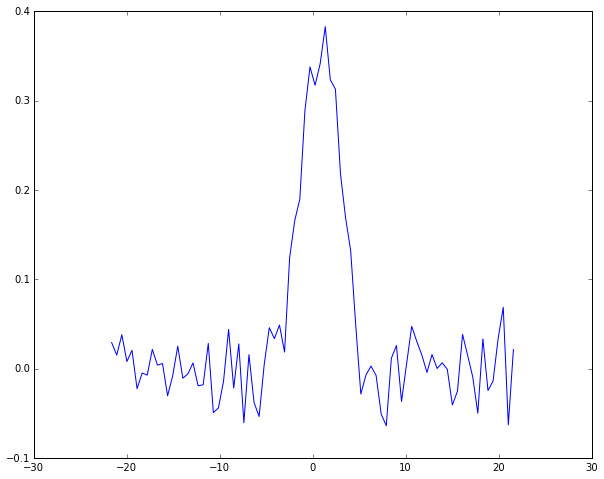

In [320]:
plot(space, -ganglion_pca)

## Fourier transform of RF

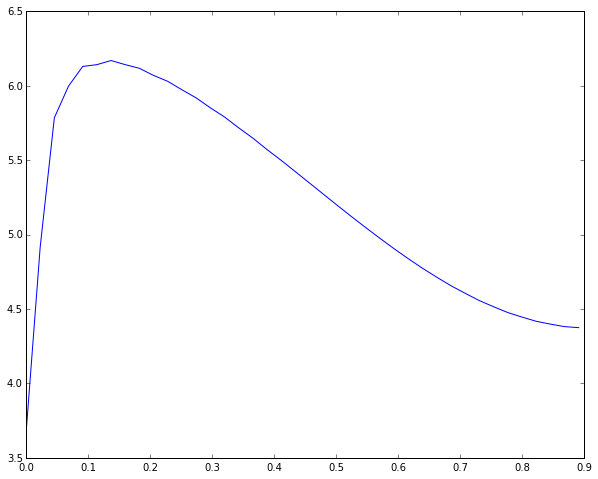

In [321]:
rf_f_two_sided = abs(fftshift(fft(rf)))
rf_f_one_sided = rf_f_two_sided[len(rf_f_two_sided)/2:]

rf_freqs_two_sided = np.fft.fftshift(np.fft.fftfreq(len(rf_f_two_sided),Fs))
rf_freqs_one_sided = rf_freqs_two_sided[len(rf_freqs_two_sided)/2:]

plot(rf_freqs_one_sided, rf_f_one_sided)

## Make ideal filter

In [322]:
# frequency axis is 'originalFreqs'
idealFilter = uniqueSoln(originalSpectra, 0.1, 0.4) # spectra, input_noise, output_noise

The error from this choice of Lagrangian multiplier is 1.4535583901e-06.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


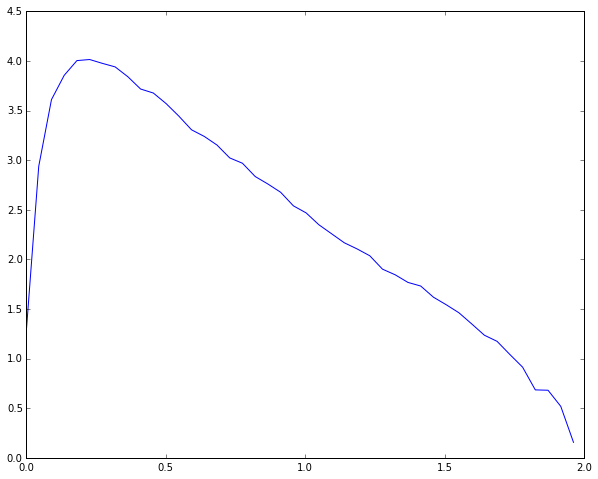

In [323]:
plot(originalFreqs, idealFilter)

## Plot ideal and ~experimental filter together

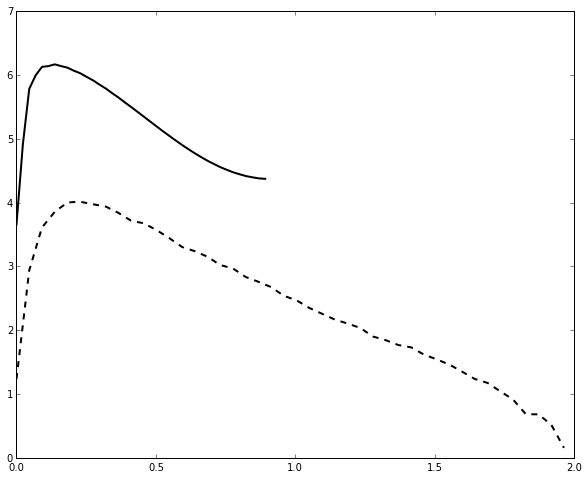

In [324]:
plot(originalFreqs, idealFilter, 'k--', linewidth=2)
plot(rf_freqs_one_sided, rf_f_one_sided, 'k', linewidth=2)

## Create function for plotting the above, just given input and output noise, and the weightings

In [325]:
def experimentVsIdeal(inputNoise=0.1, outputNoise=0.4, center_weighting=2.1, surround_weighting=0.1,
                      horz_weighting=0.5, ama_weighting=0.5, space=space, originalFreqs=originalFreqs,
                      originalSpectra=originalSpectra, horz_rf_proj_new=horz_rf_proj_new,
                      ama_rf_proj_new=ama_rf_proj_new, centerWidth=.5):
    # EXPERIMENTAL
    # make surround
    surround       = horz_weighting * horz_rf_proj_new + ama_weighting * ama_rf_proj_new

    # make center
    center         = gaussian(x=space, sigma=centerWidth, mu=space[surround==np.min(surround)]) # gaussian
    #center           = center_weighting * np.where(surround==np.min(surround), 1, 0) # delta function

    # put them together
    rf = center_weighting * center.squeeze() + surround_weighting * surround
    
    # FFT of RF
    rf_f_two_sided = abs(fftshift(fft(rf)))
    rf_f_one_sided = rf_f_two_sided[len(rf_f_two_sided)/2:]

    rf_freqs_two_sided = np.fft.fftshift(np.fft.fftfreq(len(rf_f_two_sided),Fs))
    rf_freqs_one_sided = rf_freqs_two_sided[len(rf_freqs_two_sided)/2:]
    
    
    # IDEAL
    idealFilter = uniqueSoln(originalSpectra, inputNoise, outputNoise) # spectra, input_noise, output_noise
    
    
    plot(originalFreqs, idealFilter, 'r.', linewidth=2)
    plot(rf_freqs_one_sided, rf_f_one_sided, 'k.', linewidth=2)

The error from this choice of Lagrangian multiplier is 1.95149523563e-06.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


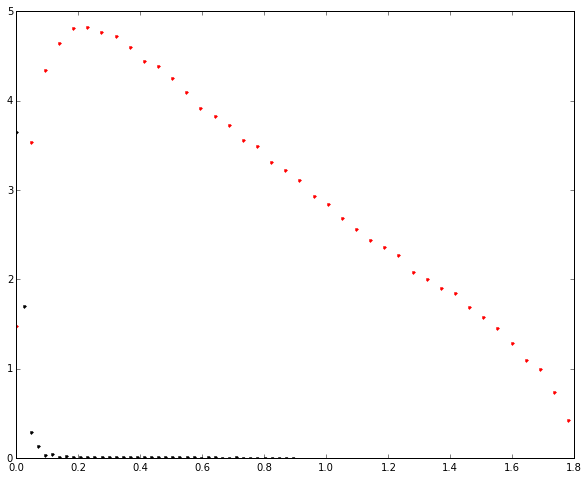

In [326]:
experimentVsIdeal(inputNoise=0.1, outputNoise=.5, surround_weighting=.1, centerWidth=0.5, 
                  ama_weighting=0.0, horz_weighting=1.0, center_weighting=0.0)

The error from this choice of Lagrangian multiplier is 0.829717886535.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


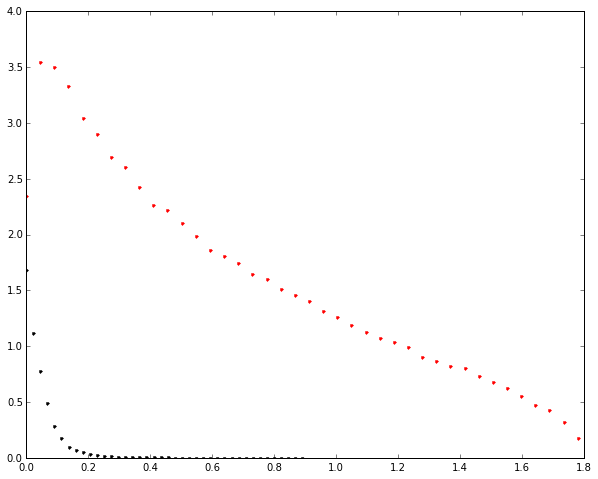

In [327]:
experimentVsIdeal(inputNoise=0.25, outputNoise=.5, surround_weighting=.1, centerWidth=0.5, 
                  ama_weighting=1.0, horz_weighting=0.0, center_weighting=0.0)

# Extrapolate low frequencies from natural image spectrum

In [328]:
from scipy.interpolate import interp1d

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


(1e-06, 1.0)

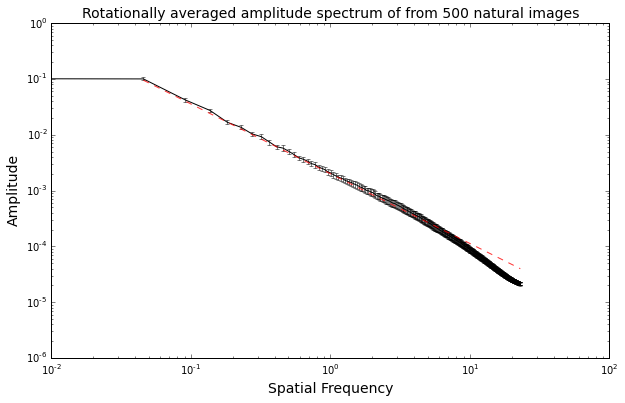

In [329]:
fig,ax = subplots()
fig.set_size_inches((10,6))

ax.errorbar(originalFreqs, originalSpectra, yerr=originalErrors, fmt='none', ecolor='k', capsize=2, capthick=1, alpha=0.5)
ax.plot(originalFreqs, originalSpectra, color='k', alpha=0.99)
# ax.plot(originalFreqs, [1.3/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
# ax.plot(originalFreqs, [0.02/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)
ax.plot(originalFreqs, [0.002/f**1.25 for f in originalFreqs], color='r', linestyle='--', alpha=0.8)

ax.set_xscale('log', nonposx='clip')
ax.set_yscale('log', nonposy='clip')

ax.set_title('Rotationally averaged amplitude spectrum of from 500 natural images', fontsize=14)
ax.set_xlabel('Spatial Frequency', fontsize=14)
ax.set_ylabel('Amplitude', fontsize=14)

ylim([10e-7,10e-1])
# ylim([10e-4,10e1])
#ylim([10e-5,1])
#savefig('Figures/00 Average power spectrum of original images.png')

In [330]:
originalFreqs[:4]

array([ 0.        ,  0.04563492,  0.09126984,  0.13690476])

In [331]:
naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='linear')

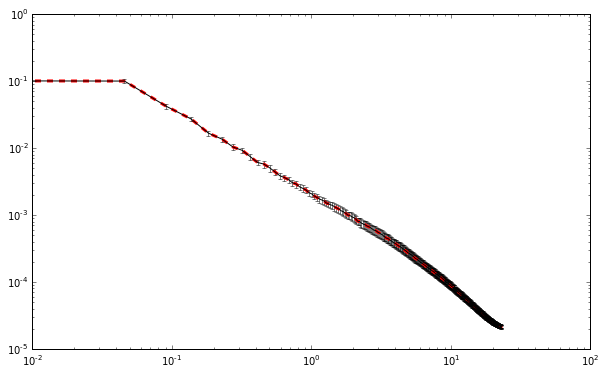

In [332]:
fig,ax = subplots()
fig.set_size_inches((10,6))

ax.plot(originalFreqs, naturalInterpolation(originalFreqs), 'r--', linewidth=3)

ax.errorbar(originalFreqs, originalSpectra, yerr=originalErrors, fmt='none', ecolor='k', capsize=2, capthick=1, alpha=0.5)
ax.plot(originalFreqs, originalSpectra, color='k', alpha=0.99)

yscale('log')
xscale('log')

In [333]:
moreFreqs   = np.linspace(0., np.max(originalFreqs), 10000)
moreSpectra = naturalInterpolation(moreFreqs)

(0.001, 100.0)

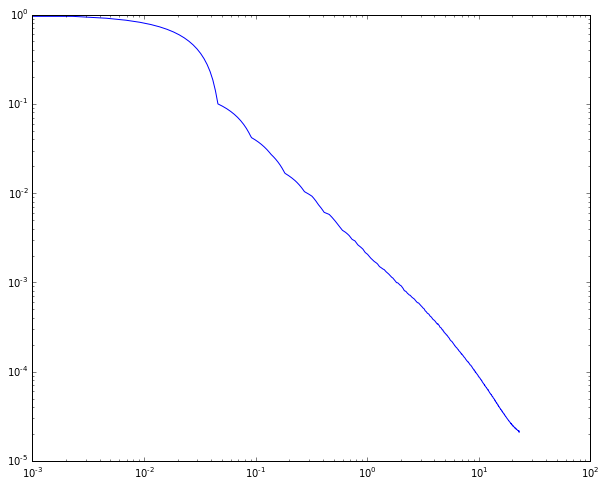

In [334]:
plot(moreFreqs, moreSpectra)
yscale('log')
xscale('log')
xlim([10e-4, 10e1])

(0.001, 100.0)

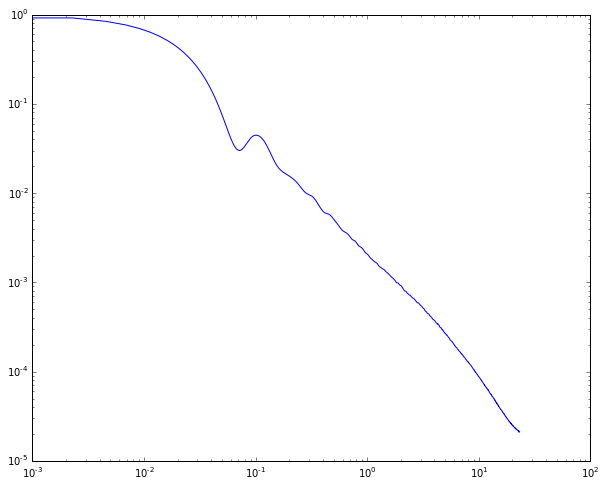

In [335]:
naturalInterpolation_dos = interp1d(originalFreqs, originalSpectra, kind='cubic')
moreFreqs   = np.linspace(0., np.max(originalFreqs), 10000)
moreSpectra = naturalInterpolation_dos(moreFreqs)
plot(moreFreqs, moreSpectra)
yscale('log')
xscale('log')
xlim([10e-4, 10e1])

In [336]:
filt = uniqueSoln(moreSpectra, 0.4, 0.1)

The error from this choice of Lagrangian multiplier is 56.2849215944.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


(0.0001, 5)

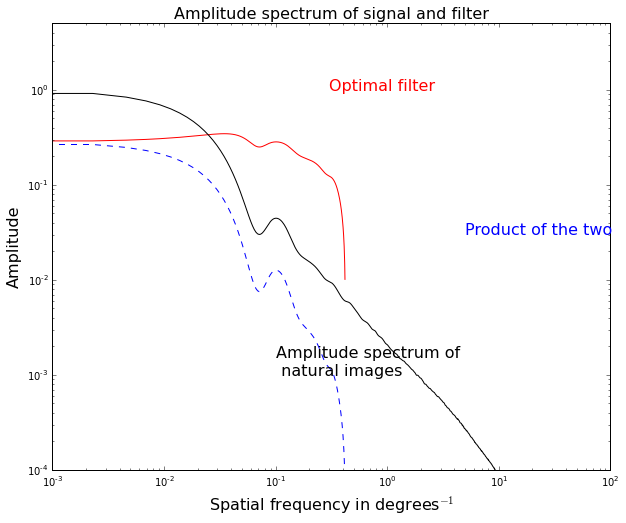

In [337]:
plot(moreFreqs,filt,'r')
plot(moreFreqs,moreSpectra,'k')
plot(moreFreqs,[f*moreSpectra[idf] for idf,f in enumerate(filt)],'b--')
yscale('log')
xscale('log')
title('Amplitude spectrum of signal and filter',fontsize=16)
xlabel('Spatial frequency in degrees' + r'$^{-1}$',fontsize=16)
ylabel('Amplitude',fontsize=16)
annotate('Optimal filter',(0.3,10e-1),fontsize=16,color='r')
annotate('Amplitude spectrum of \n natural images',(0.1,.001),fontsize=16,color='k')
annotate('Product of the two',(5.,3*10e-3),fontsize=16,color='b')

ylim([10e-5, 5])

In [338]:
filtF = filt[~np.isnan(filt)] #[complex(f) for f in filt if ~isnan(f)]
filtF = [complex(f) for f in filtF]
mask  = (1-isnan(filt))
freqF = np.where(mask.squeeze(), moreFreqs, nan)
freqF = freqF[~np.isnan(freqF)]

In [339]:
new_highest_freq = np.max(freqF)
new_spacing      = 1./(2*new_highest_freq)
degsS            = [i*new_spacing for i in xrange(-len(filtS)/2,len(filtS)/2)]

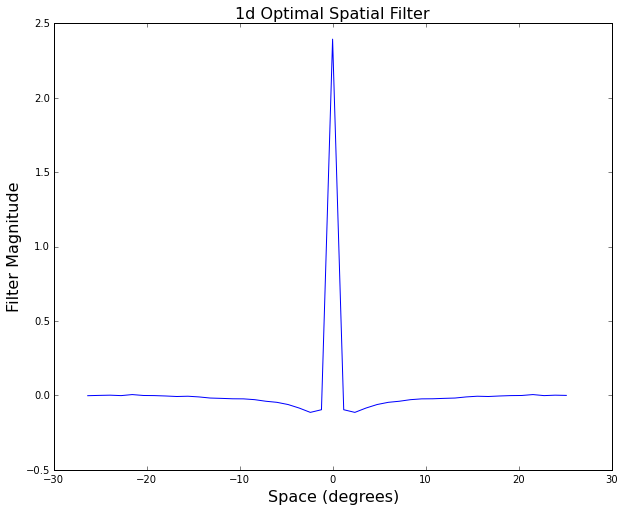

In [340]:
plot(degsS,filtS)
title('1d Optimal Spatial Filter',fontsize=16)
xlabel('Space (degrees)',fontsize=16)
ylabel('Filter Magnitude',fontsize=16)

In [341]:
def experimentVsIdeal(inputNoise=0.1, outputNoise=0.4, center_weighting=2.1, surround_weighting=0.1,
                      horz_weighting=0.5, ama_weighting=0.5, space=space, originalFreqs=originalFreqs,
                      originalSpectra=originalSpectra, horz_rf_proj_new=horz_rf_proj_new,
                      ama_rf_proj_new=ama_rf_proj_new, centerWidth=.5, interpolation='fit', 
                      returnFlag=False, plotFlag=True, verbose=True):
    # EXPERIMENTAL
    # make surround
    surround       = horz_weighting * horz_rf_proj_new + ama_weighting * ama_rf_proj_new

    # make center
    center         = gaussian(x=space, sigma=centerWidth, mu=space[surround==np.min(surround)]) # gaussian
    #center           = center_weighting * np.where(surround==np.min(surround), 1, 0) # delta function

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weighting * center + surround_weighting * surround
    
    # FFT of RF
    rf_f_two_sided = abs(fftshift(fft(rf)))
    rf_f_one_sided = rf_f_two_sided[len(rf_f_two_sided)/2:]

    rf_freqs_two_sided = np.fft.fftshift(np.fft.fftfreq(len(rf_f_two_sided),Fs))
    rf_freqs_one_sided = rf_freqs_two_sided[len(rf_freqs_two_sided)/2:]
    
    
    # IDEAL
    if interpolation == 'linear':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='linear')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'cubic':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='cubic')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'fit':
        moreFreqs   = np.linspace(0., .05*np.max(originalFreqs), 500)[1:]
        moreSpectra = [0.002/f**1.25 for f in moreFreqs]
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation is None:
        idealFilter = uniqueSoln(originalSpectra, inputNoise, outputNoise, verbose=verbose)
        
        
    
    if plotFlag:
        plot(moreFreqs, idealFilter, 'r.', linewidth=2)
        plot(rf_freqs_one_sided, rf_f_one_sided, 'k.', linewidth=2)
    
    if returnFlag:
        try:
            return moreFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided
        except:
            return originalFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided

In [342]:
moreFreqs1, idealFit, tmp1, tmp2 = experimentVsIdeal(inputNoise=0.1, outputNoise=.5, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit')
moreFreqs2, idealLin, tmp1, tmp2 = experimentVsIdeal(inputNoise=0.1, outputNoise=.5, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='linear')
moreFreqs3, idealCub, tmp1, tmp2 = experimentVsIdeal(inputNoise=0.1, outputNoise=.5, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='cubic')
moreFreqs4, idealNone, tmp1, tmp2 = experimentVsIdeal(inputNoise=0.1, outputNoise=.5, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation=None)


The error from this choice of Lagrangian multiplier is 0.000196060821054.
The error from this choice of Lagrangian multiplier is 1.0476907871e-05.
The error from this choice of Lagrangian multiplier is 2.14103870633e-07.
The error from this choice of Lagrangian multiplier is 7.38988289228e-06.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


## What is the difference in optimal filters between actual linear interpolation vs a simple log-log fit?

In [343]:
plot(moreFreqs4, idealNone, 'k', linewidth=3, alpha=0.5)
plot(moreFreqs1, idealFit, 'b', linewidth=3, alpha=0.5)
plot(moreFreqs2, idealLin, 'g', linewidth=3, alpha=0.5)
#plot(moreFreqs3, idealCub, 'c', linewidth=3, alpha=0.5)
mpld3.display()

In [344]:
moreFreqs1, idealFit, horzOnlyF, horzOnlyFilter = experimentVsIdeal(inputNoise=0.09, outputNoise=0.001, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit')
moreFreqs1, idealFit, amaOnlyF, amaOnlyFilter = experimentVsIdeal(inputNoise=0.09, outputNoise=0.001, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=1.0, horz_weighting=0.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit')

The error from this choice of Lagrangian multiplier is 25.297137065.
The error from this choice of Lagrangian multiplier is 25.297137065.


In [345]:
# interpolate horizontal and amacrine projective field filters in frequency space
horzInterpolate = interp1d(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), kind='nearest')
amaInterpolate  = interp1d(amaOnlyF,  1-amaOnlyFilter/np.max(amaOnlyFilter), kind='nearest')

horzInterpolate_x = np.linspace(np.min(horzOnlyF), np.max(horzOnlyF), len(moreFreqs1))
amaInterpolate_x  = np.linspace(np.min(amaOnlyF), np.max(amaOnlyF), len(moreFreqs1))

In [346]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.')
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.')
#plot(horzInterpolate_x, horzInterpolate(horzInterpolate_x), 'g')
#plot(amaInterpolate_x, amaInterpolate(amaInterpolate_x), 'c')
plot(moreFreqs1, idealFit/np.max(idealFit[~isnan(idealFit)]), 'b', linewidth=3, alpha=0.5)
xlim([0,0.4])
xlabel('Spatial frequency (1/deg)', fontsize=16)
ylabel('Normalized amplitude', fontsize=16)
mpld3.display()

In [347]:
horz_exp_fit = 4*np.exp(-50.*horzInterpolate_x)

plot(horzInterpolate_x, 1 - horz_exp_fit/np.max(horz_exp_fit),'g')
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', linewidth=2)
plot(moreFreqs1, idealFit/np.max(idealFit[~isnan(idealFit)]))
xlim([0,0.2])
mpld3.display()

In [348]:
def func(x, a, b, c):
    # exponential
    y = a * np.exp(-b * x) + c
    
    # power law
    #y = a / x**b + c
    #y[x==0] = np.max(y[np.isfinite(y)])
    
    return 1 - y/np.max(y)

popt, pcov = curve_fit(func, horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter))

In [349]:
popt

array([  6.75856070e+01,   4.08682830e+01,  -2.67826639e-02])

In [353]:
y = func(horzInterpolate_x, *popt)

(0, 0.2)

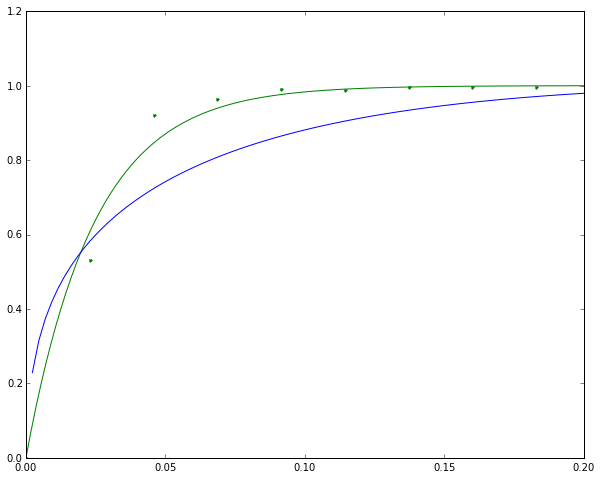

In [355]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', linewidth=2)
#plot(horzInterpolate_x[1:], y, 'g')
plot(horzInterpolate_x, y, 'g')
plot(moreFreqs1, idealFit/np.max(idealFit[~isnan(idealFit)]))
xlim([0,0.2])

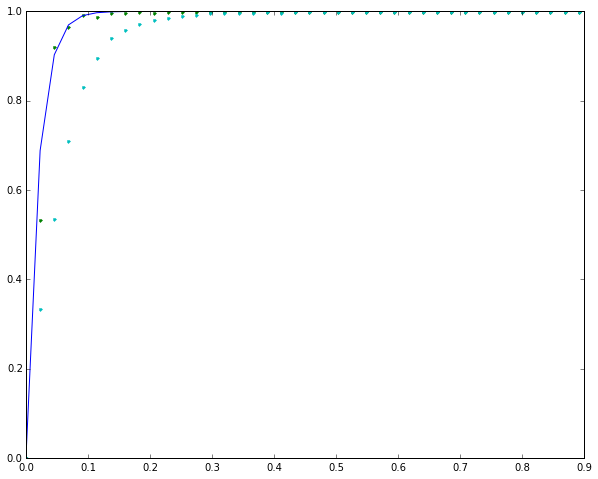

In [356]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.')
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.')

plot(horzOnlyF, 1-np.exp(-51*horzOnlyF))

In [357]:
np.exp(p[1])

array([ 1.91440076,  1.93506054,  1.93506054, ...,  2.16591999,
        2.17757569,  2.21292048])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


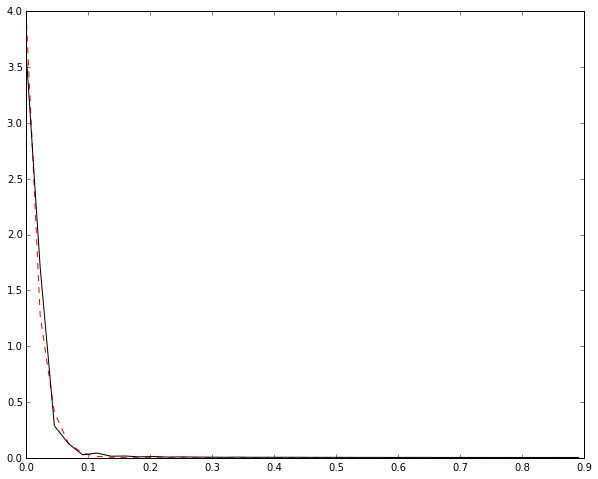

In [358]:
tmp_x = np.log(horzOnlyF)
tmp_y = np.log(horzOnlyFilter)

p = np.polyfit(horzOnlyF, np.log(horzOnlyFilter), 1)
fitted_exp = 4*np.exp(-50.*horzOnlyF)

plot(horzOnlyF, fitted_exp,'r--')
plot(horzOnlyF, horzOnlyFilter,'k')

# Find the parameters that minimize distance between ideal filter and experiment

In [359]:
def mse(x,y):
    return np.mean((x-y)**2)

In [360]:
def relativeError(x,y):
    return np.mean(np.abs(x-y)/(np.abs(x)+np.abs(y)))

In [361]:
def align(x1,y1,x2,y2,mode='linear',points=1000):
    if len(x1.shape) > 1:
        x1 = x1.squeeze()
    if len(x2.shape) > 1:
        x2 = x2.squeeze()
    if len(y1.shape) > 1:
        y1 = y1.squeeze()
    if len(y2.shape) > 1:
        y2 = y2.squeeze()
        
    y1_hd = interp1d(x1,y1, kind=mode)
    y2_hd = interp1d(x2,y2, kind=mode)
    
    x3 = np.linspace(np.max([np.min(x1),np.min(x2)]), np.min([np.max(x1), np.max(x2)]), points)
    return y1_hd(x3), y2_hd(x3)
    

In [362]:
def objectiveFn(params, interpolation_type='fit'):
    # unpack parameters
    inputNoise, outputNoise, ama_weighting, horz_weighting, surround_weighting, center_weighting, centerWidth = params
    inputNoise = np.max([inputNoise, 0])
    outputNoise = np.max([outputNoise, 0])
    centerWidth = np.max([centerWidth, 0])
    # get ideal and experimental filters according to the parameters
    x_ideal, y_ideal, x_expt, y_expt = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise,
                                                         surround_weighting=surround_weighting,
                                                         centerWidth=centerWidth, ama_weighting=ama_weighting,
                                                         horz_weighting=horz_weighting, 
                                                         center_weighting=center_weighting, 
                                                         returnFlag=True, plotFlag=False,
                                                         interpolation=interpolation_type, verbose=False)
    # remove any nans from the ideal filter
    if len(y_ideal.shape) > 1:
        y_ideal = y_ideal.squeeze()
    x_ideal = x_ideal[~isnan(y_ideal)]
    y_ideal = y_ideal[~isnan(y_ideal)]
    
    # align the filters so they have the same x axis scale
    y_ideal_trunc, y_expt_trunc = align(x_ideal, y_ideal, x_expt, y_expt)
    
    return relativeError(y_ideal_trunc, y_expt_trunc) #mse(y_ideal_trunc, y_expt_trunc)
    

In [363]:
def sgd(params, f, num_iters=1000, learning_rate=0.001, h=1e-5):
    loss_history = []
    for i in xrange(num_iters):        
        grads = np.zeros_like(params)
        for idp,p in enumerate(params):
            #old_params = params.copy()
            params_p   = params.copy()
            params_m   = params.copy()
            params_p[idp] += h
            params_m[idp] -= h
            
            grads[idp] = (f(params_p) - f(params_m))/(2*h)

        # update step
        params -= learning_rate * grads
        
        #import pdb
        #pdb.set_trace()
        
        # keep track of loss
        loss_history.append(f(params))
        
        if i % 5 == 0:
            print 'Finishing iteration %d / %d' %(i,num_iters)
        
    return params, loss_history

In [364]:
#params = [inputNoise, outputNoise, ama_weighting, horz_weighting, surround_weighting, center_weighting, center_width]
#params = np.array([0.1, 0.5, 0.5, 0.5, 0.1, 2.1, .25])
#params = np.array([0.16649304,  0.47750845,  0.50479248,  0.50369971,  0.13725742,  2.08108241,  0.39117455])
#params = np.array([ 0.21932059,  0.40584127,  0.50760454,  0.49049742,  0.10568436, 2.06907593,  0.49609932])
params = np.array([ 0.24718056,  0.3917271 ,  0.50767963,  0.49008901,  0.10390758, 2.06822685,  0.50269057])
learning_rate = 0.0005 #0.001
num_iters = 100
opt_params, loss_history = sgd(params, objectiveFn, num_iters=num_iters, learning_rate=learning_rate)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()
/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/scipy/optimize/optimize.py:456: RuntimeWarning: invalid value encountered in absolute
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= ftol):


Finishing iteration 0 / 100


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


ValueError: total size of new array must be unchanged

In [ ]:
plot(loss_history)
xlabel('Iterations', fontsize=16)
ylabel('Loss', fontsize=16)

In [ ]:
params

In [ ]:
opt_params

In [365]:
params = np.array([ 0.24718056,  0.3917271 ,  0.50767963,  0.49008901,  0.10390758, 2.06822685,  0.50269057])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


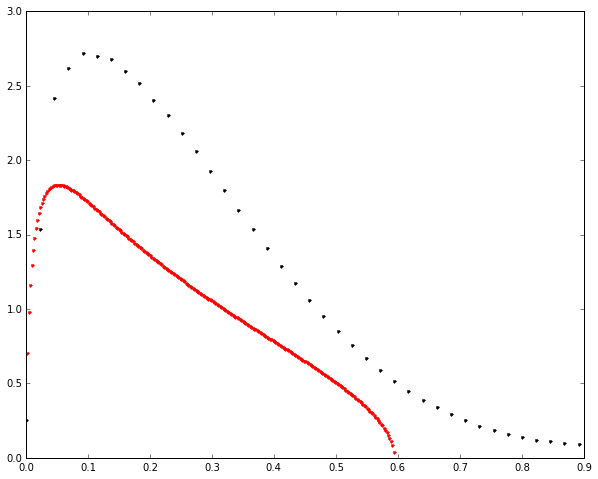

In [366]:
inputNoise, outputNoise, ama_weighting, horz_weighting, surround_weighting, center_weighting, centerWidth = params
experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=surround_weighting,
                  centerWidth=centerWidth, ama_weighting=ama_weighting, horz_weighting=horz_weighting, 
                  center_weighting=center_weighting, returnFlag=False, plotFlag=True, 
                  interpolation='fit', verbose=False)

### Troubleshoot `invalid value encountered in sqrt'

In [367]:
R_0 = idealFit

(outputNoise/inputNoise)*np.sqrt([0.5*(r0/(r0+inputNoise**2))*(1 + np.sqrt(1+(2*lagrangeMultiplier*inputNoise**2)/r0))-1 for r0 in R_0])

NameError: name 'lagrangeMultiplier' is not defined

In [368]:
np.sqrt(0.4)

0.63245553203367588

## Just fit horizontal and amacrine cells with an exponential  
Unfortunately, here we are not constraining the total noise to be equal to Pablo's SNR measurement at 35% contrast.

In [369]:
inputNoise=0.085
outputNoise=0.06
totalNoise = inputNoise + outputNoise

moreFreqs1, idealFit, horzOnlyF, horzOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit')
moreFreqs1, idealFit, amaOnlyF, amaOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=1.0, horz_weighting=0.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit')

The error from this choice of Lagrangian multiplier is 4.02151514578e-06.
The error from this choice of Lagrangian multiplier is 8.44740760897e-07.


In [370]:
flag = 'exp'

if flag == 'interp':
    # interpolate horizontal and amacrine projective field filters in frequency space
    horzInterpolate = interp1d(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), kind='slinear')
    amaInterpolate  = interp1d(amaOnlyF,  1-amaOnlyFilter/np.max(amaOnlyFilter), kind='slinear')

    horzInterpolate_x = np.linspace(np.min(horzOnlyF), np.max(horzOnlyF), len(moreFreqs1))
    amaInterpolate_x  = np.linspace(np.min(amaOnlyF), np.max(amaOnlyF), len(moreFreqs1))
elif flag == 'exp':
    def func(x, a, b, c):
        # exponential
        y = a * np.exp(-b * x) + c

        # power law
        #y = a / x**b + c
        #y[x==0] = np.max(y[np.isfinite(y)])

        return 1 - y/np.max(y)

    popt_horz, pcov_horz = curve_fit(func, horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter))
    popt_ama, pcov_ama   = curve_fit(func, amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter))
    
    horzInterpolate_x = np.linspace(np.min(horzOnlyF), np.max(horzOnlyF), len(moreFreqs1))
    amaInterpolate_x  = np.linspace(np.min(amaOnlyF), np.max(amaOnlyF), len(moreFreqs1))
    
    horzExpFit = func(horzInterpolate_x, *popt_horz)
    amaExpFit  = func(amaInterpolate_x, *popt_ama)

In [371]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', markersize=10)
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.', markersize=10)
if flag == 'interp':
    plot(horzInterpolate_x, horzInterpolate(horzInterpolate_x), 'g')
    plot(amaInterpolate_x, amaInterpolate(amaInterpolate_x), 'c')
elif flag == 'exp':
    plot(horzInterpolate_x, horzExpFit, 'g')
    plot(amaInterpolate_x, amaExpFit, 'c')
    
plot(moreFreqs1, idealFit/np.max(idealFit[~isnan(idealFit)]), 'b', linewidth=3, alpha=0.5)
xlim([0,0.25])
xlabel('Spatial frequency (1/deg)', fontsize=16)
ylabel('Normalized amplitude', fontsize=16)
annotate('Amacrine cell', [0.1, 0.6], fontsize=16, color='c')
annotate('Horizontal cell', [0.15, 1.1], fontsize=16, color='g')
annotate('Ideal infomax filter', [0.125, 0.8], fontsize=16, color='b', alpha=0.5)
print 'The total noise is %f.' %(totalNoise)
mpld3.display()

The total noise is 0.145000.


### Troubleshoot `invalid value encountered in sqrt'

In [394]:
R_0 = originalSpectra

In [395]:
lagrangeMultiplier = 1000.
blastoid = (outputNoise/inputNoise)*np.sqrt([0.5*(r0/(r0+inputNoise**2))*(1 + np.sqrt(1+(2*lagrangeMultiplier*inputNoise**2)/r0))-1 for r0 in R_0])

In [396]:
lagrangeMultiplier = 100.
centroid = (outputNoise/inputNoise)*np.sqrt([0.5*(r0/(r0+inputNoise**2))*(1 + np.sqrt(1+(2*lagrangeMultiplier*inputNoise**2)/r0))-1 for r0 in R_0])

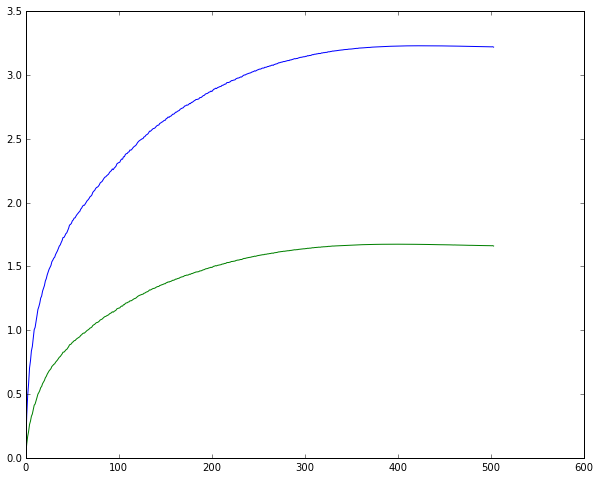

In [397]:
plot(range(len(originalSpectra)),blastoid)
plot(range(len(originalSpectra)),centroid)

In [398]:
np.var(R_0)

0.0020035881728221643

In [399]:
moreFreqs   = np.linspace(0., 0.015*np.max(originalFreqs), 500)[1:]
moreSpectra = [0.002/f**1.25 for f in moreFreqs]

In [400]:
np.var(moreSpectra)/totalNoise

84.172562586517955

In [401]:
thisSNR = (100*originalSpectra/(inputNoise * 100*originalSpectra + outputNoise))**2

In [402]:
np.mean(thisSNR)

465.20436054549128

In [403]:
(outputNoise/inputNoise)*np.sqrt([0.5*(r0/(r0+inputNoise**2))*(1 + np.sqrt(1+(2*lagrangeMultiplier*inputNoise**2)/r0))-1 for r0 in R_0])

array([ 0.03497729,  0.10989471,  0.16830644,  0.20729292,  0.26145631,
        0.28753388,  0.32569566,  0.34311046,  0.3783238 ,  0.41215424,
        0.42197549,  0.44609926,  0.47244851,  0.49935998,  0.51175989,
        0.52746541,  0.55012225,  0.55924371,  0.58137447,  0.59355605,
        0.6066845 ,  0.62766472,  0.63829188,  0.65573164,  0.66864496,
        0.6812241 ,  0.68955603,  0.69874846,  0.71606331,  0.72313793,
        0.73239609,  0.73668607,  0.74958471,  0.75789292,  0.76647753,
        0.77767539,  0.78842212,  0.79390728,  0.80476795,  0.81418615,
        0.82829025,  0.82848192,  0.83609501,  0.84579243,  0.84977637,
        0.8598889 ,  0.87089279,  0.885994  ,  0.88873905,  0.89400007,
        0.90535837,  0.90971305,  0.9184424 ,  0.9196055 ,  0.92802913,
        0.93467491,  0.93972605,  0.94558556,  0.94900106,  0.95940094,
        0.96453305,  0.97307675,  0.97772953,  0.97768264,  0.98479911,
        0.99152755,  0.99919316,  1.00303414,  1.00889542,  1.01

In [404]:
[np.sqrt(1+(2*lagrangeMultiplier*inputNoise**2)/r0) for r0 in R_0]

[1.0024968827881711,
 1.0246589838323097,
 1.0578789327325848,
 1.0878537879306815,
 1.1399176046709922,
 1.169328448031592,
 1.2174897263430438,
 1.2415000655153412,
 1.2939664724207938,
 1.3493436961050023,
 1.3663390464789824,
 1.4098514384291041,
 1.4602665359002736,
 1.5148989811929574,
 1.5411492391884818,
 1.575380481693494,
 1.6267128914537772,
 1.6480341233244129,
 1.7013417377692326,
 1.7316447224120461,
 1.7650733949566344,
 1.8201685528820108,
 1.8488688219049751,
 1.8971349958515851,
 1.9338172514463667,
 1.9703298729576844,
 1.9949414824734024,
 2.0224928415862009,
 2.075532506356641,
 2.0976377675776341,
 2.1269496382354753,
 2.1406803784405275,
 2.1825351035746521,
 2.2099513091332441,
 2.2386592008571418,
 2.2766910989857081,
 2.3138198943859911,
 2.3330102203331626,
 2.3714896901657703,
 2.4053822463278043,
 2.4570588772763,
 2.4577688230550678,
 2.4861355688835465,
 2.5227460969991298,
 2.5379429444671406,
 2.5769304407901101,
 2.6200344696885649,
 2.6803601101222583

In [406]:
r0 = originalSpectra
N  = inputNoise
r  = r0 + N**2

f = .5 * r0/(r * N**2) * (1 + np.sqrt(1 + (2 * lagrangeMultiplier * N**2)/r0)) - 1

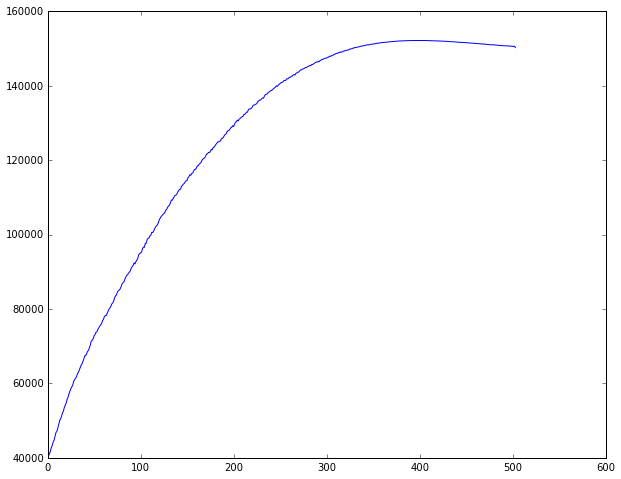

In [407]:
plot(f)

In [408]:
def getLambda(r0, inputNoise, outputNoise):
    
    N = inputNoise
    def lhs(lam):
        #return np.sum(np.log([np.sqrt(r/(2*lam*inputNoise**2))+np.sqrt(1+(r/2*lam*inputNoise**2)) for r in R_0]))
        return np.sum(np.log(np.sqrt(r0/(2 * lam * N**2)) + np.sqrt(1 + (r0/(2 * lam * N**2)))))
    
    #R = np.array(R_0) + inputNoise**2
    r0 = np.array(r0)
    r  = r0 + N**2
    #rhs = 0.5*np.sum(np.log([(r*(inputNoise**2 + outputNoise**2))/(inputNoise**2 * (r + outputNoise**2)) for r in R]))
    rhs = 0.5 * np.sum(np.log((r/(N**2)) * ((N**2 + outputNoise**2)/(r + outputNoise**2))))
    
    def relativeDifference(lam):
        left = lhs(lam)
        return abs(left-rhs)/(abs(left) + abs(rhs))
    
    lam = 5*rand(1)
    res = minimize(relativeDifference, x0=lam, method='nelder-mead')
    
    return res.x, res.fun

In [409]:
np.sum(np.log(np.sqrt(r0/(2 * lagrangeMultiplier * N**2)) + np.sqrt(1 + (r0/(2 * lagrangeMultiplier * N**2)))))

99.718807235142549

In [410]:
.5 * np.sum(np.log((r/(N**2)) * ((N**2 + outputNoise**2)/(r + outputNoise**2))))

116.94294975144689

In [411]:
lam, err = getLambda(originalSpectra, 0.01, 0.5)

In [412]:
lam

array([ 3.54806782])

In [413]:
err

1.6061519482523995e-06

In [414]:
def uniqueSoln(r0, inputNoise, outputNoise, verbose=True):
    '''R_0 is input covariance matrix
       R is R_0 + N^2 delta_n,m'''
    #R = np.array(R_0) + inputNoise**2 #* np.eye(*R_0.shape)
    
    #import pdb
    #pdb.set_trace()
    
    N  = inputNoise
    r0 = np.array(r0)
    r  = r0 + N**2
    
    lam, relErr = getLambda(r0, inputNoise, outputNoise)
    if verbose:
        print 'The relative error from this choice of Lagrangian multiplier is %s.' %(relErr)
        
    #import pdb
    #pdb.set_trace()
    
    f = ((1. / N**2) * (.5 * r0/r * (1 + np.sqrt(1 + (2 * lam * N**2)/r0)) - 1)).astype(complex)
    
    return real(outputNoise * np.sqrt(f))

In [415]:
filt = uniqueSoln(originalSpectra, 0.4, 0.1)

The relative error from this choice of Lagrangian multiplier is 2.79217347718e-10.


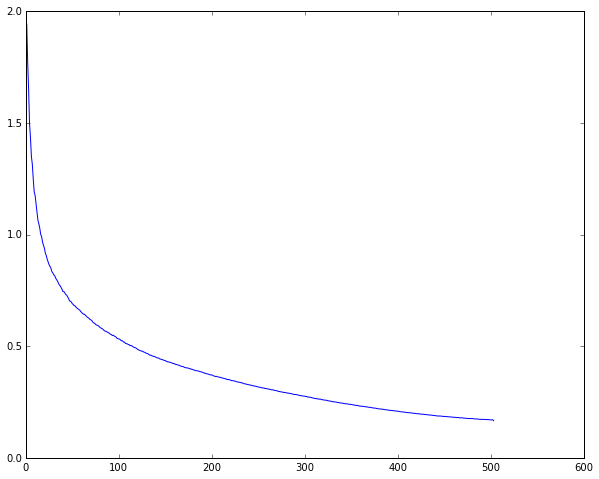

In [416]:
plot(filt)

In [417]:
inputNoises  = np.logspace(-4,2,5)
outputNoises = np.logspace(-4,2,5)
filts = {}
for N in inputNoises:
    for N_del in outputNoises:
        filts[(N,N_del)] = uniqueSoln(originalSpectra, N, N_del, verbose=False)

# Do the results still hold?

In [418]:
def experimentVsIdeal(inputNoise=0.1, outputNoise=0.4, center_weighting=2.1, surround_weighting=0.1,
                      horz_weighting=0.5, ama_weighting=0.5, space=space, originalFreqs=originalFreqs,
                      originalSpectra=originalSpectra, horz_rf_proj_new=horz_rf_proj_new,
                      ama_rf_proj_new=ama_rf_proj_new, centerWidth=.5, interpolation='fit', 
                      returnFlag=False, plotFlag=True, verbose=True):
    # EXPERIMENTAL
    # make surround
    surround       = horz_weighting * horz_rf_proj_new + ama_weighting * ama_rf_proj_new

    # make center
    center         = gaussian(x=space, sigma=centerWidth, mu=space[surround==np.min(surround)]) # gaussian
    #center           = center_weighting * np.where(surround==np.min(surround), 1, 0) # delta function

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weighting * center + surround_weighting * surround
    
    # FFT of RF
    rf_f_two_sided = abs(fftshift(fft(rf)))
    rf_f_one_sided = rf_f_two_sided[len(rf_f_two_sided)/2:]

    rf_freqs_two_sided = np.fft.fftshift(np.fft.fftfreq(len(rf_f_two_sided),Fs))
    rf_freqs_one_sided = rf_freqs_two_sided[len(rf_freqs_two_sided)/2:]
    
    
    # IDEAL
    if interpolation == 'linear':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='linear')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'cubic':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='cubic')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'fit':
        moreFreqs   = np.linspace(0., .05*np.max(originalFreqs), 1000)[1:]
        moreSpectra = np.array([0.002/f**1.25 for f in moreFreqs])
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation is None:
        idealFilter = uniqueSoln(originalSpectra, inputNoise, outputNoise, verbose=verbose)
        
        
    
    if plotFlag:
        plot(moreFreqs, idealFilter, 'r.', linewidth=2)
        plot(rf_freqs_one_sided, rf_f_one_sided, 'k.', linewidth=2)
    
    if returnFlag:
        try:
            return moreFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided
        except:
            return originalFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided

In [419]:
inputNoise=0.085
outputNoise=0.06
totalNoise = inputNoise + outputNoise

moreFreqs1, idealFit, horzOnlyF, horzOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit')
moreFreqs1, idealFit, amaOnlyF, amaOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=1.0, horz_weighting=0.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit')

The relative error from this choice of Lagrangian multiplier is 9.71848810925e-08.
The relative error from this choice of Lagrangian multiplier is 7.96116856991e-10.


In [420]:
flag = 'exp'

if flag == 'interp':
    # interpolate horizontal and amacrine projective field filters in frequency space
    horzInterpolate = interp1d(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), kind='slinear')
    amaInterpolate  = interp1d(amaOnlyF,  1-amaOnlyFilter/np.max(amaOnlyFilter), kind='slinear')

    horzInterpolate_x = np.linspace(np.min(horzOnlyF), np.max(horzOnlyF), len(moreFreqs1))
    amaInterpolate_x  = np.linspace(np.min(amaOnlyF), np.max(amaOnlyF), len(moreFreqs1))
elif flag == 'exp':
    def func(x, a, b, c):
        # exponential
        y = a * np.exp(-b * x) + c

        # power law
        #y = a / x**b + c
        #y[x==0] = np.max(y[np.isfinite(y)])

        return 1 - y/np.max(y)

    popt_horz, pcov_horz = curve_fit(func, horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter))
    popt_ama, pcov_ama   = curve_fit(func, amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter))
    
    horzInterpolate_x = np.linspace(np.min(horzOnlyF), np.max(horzOnlyF), len(moreFreqs1))
    amaInterpolate_x  = np.linspace(np.min(amaOnlyF), np.max(amaOnlyF), len(moreFreqs1))
    
    horzExpFit = func(horzInterpolate_x, *popt_horz)
    amaExpFit  = func(amaInterpolate_x, *popt_ama)

In [421]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', markersize=10)
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.', markersize=10)
if flag == 'interp':
    plot(horzInterpolate_x, horzInterpolate(horzInterpolate_x), 'g')
    plot(amaInterpolate_x, amaInterpolate(amaInterpolate_x), 'c')
elif flag == 'exp':
    plot(horzInterpolate_x, horzExpFit, 'g')
    plot(amaInterpolate_x, amaExpFit, 'c')
    
plot(moreFreqs1, idealFit/np.max(idealFit), 'b', linewidth=3, alpha=0.5)
xlim([0,0.25])
xlabel('Spatial frequency (1/deg)', fontsize=16)
ylabel('Normalized amplitude', fontsize=16)
annotate('Amacrine cell', [0.1, 0.6], fontsize=16, color='c')
annotate('Horizontal cell', [0.15, 1.1], fontsize=16, color='g')
annotate('Ideal infomax filter', [0.125, 0.8], fontsize=16, color='b', alpha=0.5)
print 'The total noise is %f.' %(totalNoise)
mpld3.display()

The total noise is 0.145000.


# Compute SNR

In [422]:
moreFreqs   = np.linspace(0., 1.0*np.max(originalFreqs), 5000)[1:]
moreSpectra = np.array([0.002/f**1.25 for f in moreFreqs])

thisSNR = np.mean((moreSpectra / (inputNoise**2 * moreSpectra + outputNoise**2))**2)

In [423]:
thisSNR

6.83969217017472

#### Why does the SNR depend on the resolution of my moreFreqs? That just seems wrong. It also seems worrying that my filter shape isn't changing when I input a smaller range of moreFreqs, yet the SNR changes dramatically on what range I get (since for far out, where the natural image spectrum is very close to zero, the output noise becomes larger and larger).

## So changing the magnitude of the natural image amplitude spectrum does have a big affect on the filter, because you're essentially changing the signal to noise ratio. But still, why is the SNR changing for altering resolution or spatial extent of the natural image amplitude, when the filter shape is not changing?

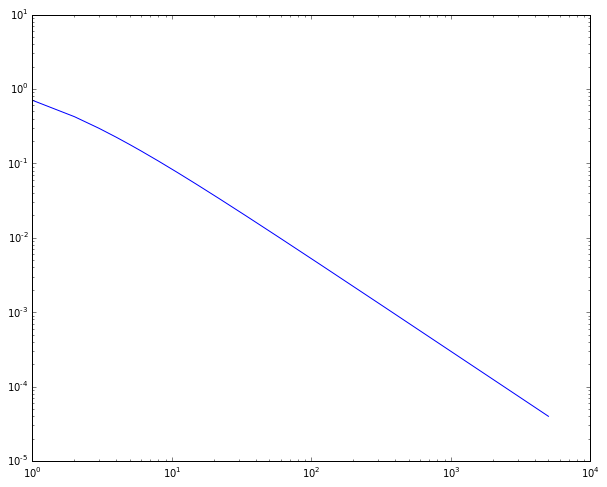

In [424]:
plot(moreSpectra)
yscale('log')
xscale('log')

### The variance of the signal is = to the sum of the power across all frequency bands

In [425]:
signalVar = np.sum(moreSpectra**2)
print 'So the signal variance is %f.' %(signalVar)

So the signal variance is 3.755697.


In [426]:
inputVar = np.sum((moreSpectra + inputNoise**2)**2)

### Should the input amplitude spectrum actually be the power spectrum????

## On one hand N**2 is added to R_0, but on the other hand we just take the FFT of R_0. Is the FFT of the covariance matrix the power spectrum of the original signal?

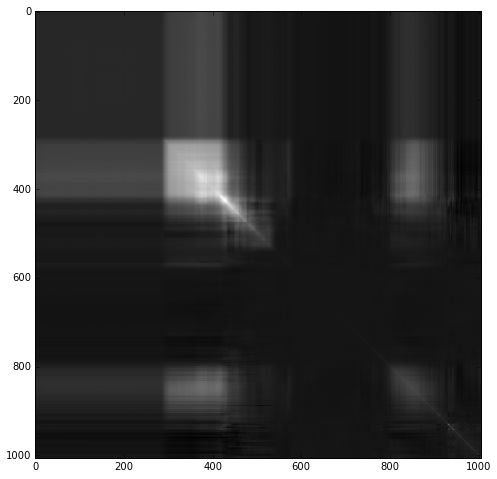

In [427]:
imshow(np.cov(patches[6]))

In [428]:
allCov = [np.cov(p) for p in patches]
meanCov = np.mean(allCov, axis=0)

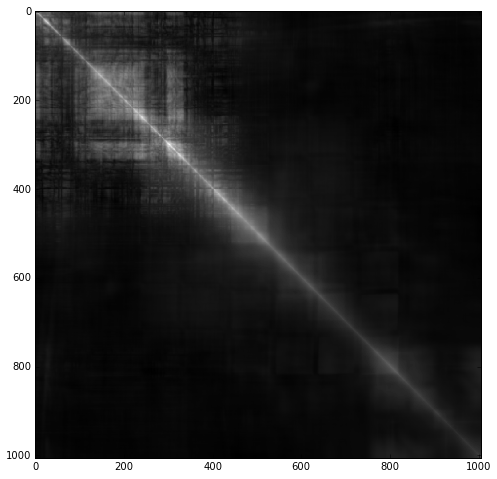

In [429]:
imshow(meanCov)

In [430]:
abs(fft(meanCov))

array([[ 45.49742168,  31.30117624,  12.41701878, ...,   2.38759853,
         12.41701878,  31.30117624],
       [ 45.6731791 ,  30.92882521,  12.15659158, ...,   2.72962493,
         12.15659158,  30.92882521],
       [ 44.6058574 ,  29.90453899,  12.18570312, ...,   3.22489288,
         12.18570312,  29.90453899],
       ..., 
       [ 10.33626129,  10.8334048 ,   5.47711221, ...,   1.10482241,
          5.47711221,  10.8334048 ],
       [ 10.239808  ,  10.81681612,   5.45306521, ...,   1.01982321,
          5.45306521,  10.81681612],
       [ 10.20283642,  10.79361038,   5.41335776, ...,   0.98943655,
          5.41335776,  10.79361038]])

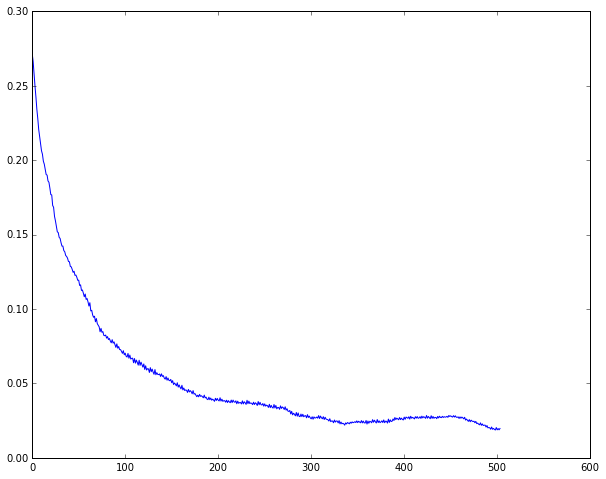

In [431]:
plot(rotavg(meanCov))

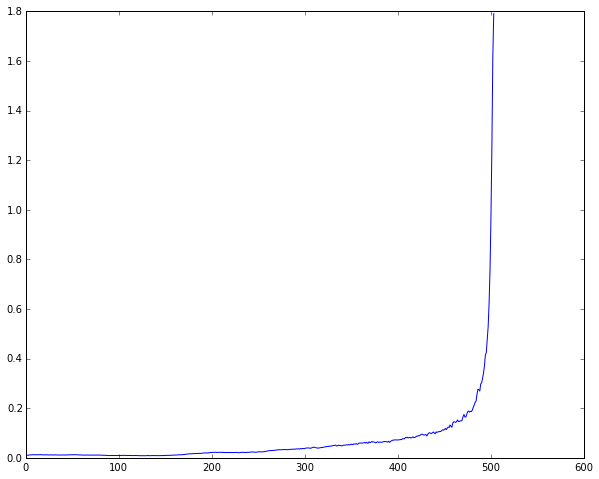

In [432]:
plot(rotavg(abs(fft(meanCov))))

In [433]:
new_r0 = rotavg(abs(fft(meanCov)))[::-1]

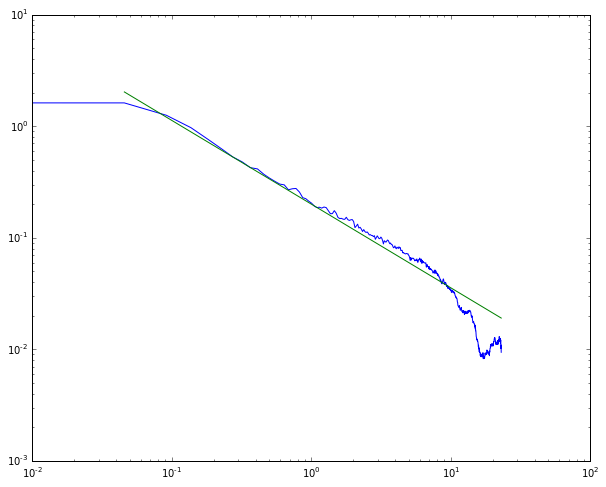

In [434]:
plot(originalFreqs, new_r0)
plot(originalFreqs[1:], [0.2/f**0.75 for f in originalFreqs[1:]]) # originally had power of 1.25
xscale('log')
yscale('log')

In [435]:
new_filt = uniqueSoln(new_r0, 0.4, 0.1)

The relative error from this choice of Lagrangian multiplier is 3.21826970478e-09.


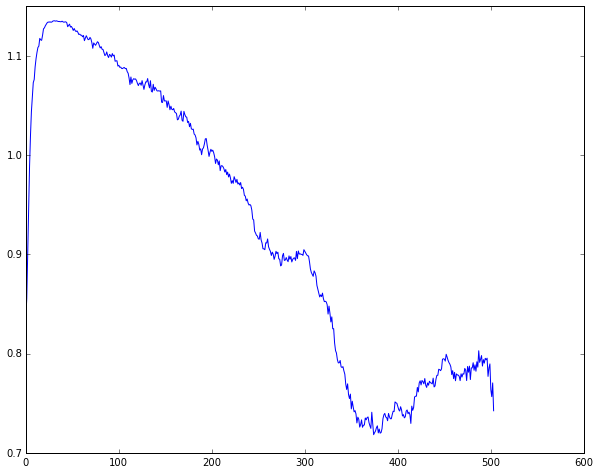

In [436]:
plot(new_filt)

## How does the filter change with respect to horz, ama cells with this new R_0?

In [437]:
def experimentVsIdeal(inputNoise=0.1, outputNoise=0.4, center_weighting=2.1, surround_weighting=0.1,
                      horz_weighting=0.5, ama_weighting=0.5, space=space, originalFreqs=originalFreqs,
                      originalSpectra=originalSpectra, horz_rf_proj_new=horz_rf_proj_new,
                      ama_rf_proj_new=ama_rf_proj_new, centerWidth=.5, interpolation='fit', 
                      returnFlag=False, plotFlag=True, verbose=True):
    # EXPERIMENTAL
    # make surround
    surround       = horz_weighting * horz_rf_proj_new + ama_weighting * ama_rf_proj_new

    # make center
    center         = gaussian(x=space, sigma=centerWidth, mu=space[surround==np.min(surround)]) # gaussian
    #center           = center_weighting * np.where(surround==np.min(surround), 1, 0) # delta function

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weighting * center + surround_weighting * surround
    
    # FFT of RF
    rf_f_two_sided = abs(fftshift(fft(rf)))
    rf_f_one_sided = rf_f_two_sided[len(rf_f_two_sided)/2:]

    rf_freqs_two_sided = np.fft.fftshift(np.fft.fftfreq(len(rf_f_two_sided),Fs))
    rf_freqs_one_sided = rf_freqs_two_sided[len(rf_freqs_two_sided)/2:]
    
    
    # IDEAL
    if interpolation == 'linear':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='linear')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'cubic':
        naturalInterpolation = interp1d(originalFreqs, originalSpectra, kind='cubic')
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 1000)
        moreSpectra = naturalInterpolation(moreFreqs)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation == 'fit':
        def func(x, a, b, c):
            return a/(x**b) + c
        popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
        moreFreqs   = np.linspace(0., np.max(originalFreqs), 5000)[1:]
        moreSpectra = func(moreFreqs, *popt)
        idealFilter = uniqueSoln(moreSpectra, inputNoise, outputNoise, verbose=verbose) # spectra, input_noise, output_noise
    elif interpolation is None:
        idealFilter = uniqueSoln(originalSpectra, inputNoise, outputNoise, verbose=verbose)
        
        
    
    if plotFlag:
        plot(moreFreqs, idealFilter, 'r.', linewidth=2)
        plot(rf_freqs_one_sided, rf_f_one_sided, 'k.', linewidth=2)
    
    if returnFlag:
        try:
            return moreFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided
        except:
            return originalFreqs, idealFilter, rf_freqs_one_sided, rf_f_one_sided

In [438]:
inputNoise=.5
outputNoise=.4
totalNoise = inputNoise + outputNoise

moreFreqs1, idealFit, horzOnlyF, horzOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit', originalSpectra=new_r0)
moreFreqs1, idealFit, amaOnlyF, amaOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=1.0, horz_weighting=0.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit', originalSpectra=new_r0)

The relative error from this choice of Lagrangian multiplier is 3.03790871285e-08.
The relative error from this choice of Lagrangian multiplier is 8.9400858785e-08.


In [440]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', markersize=10)
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.', markersize=10)
if flag == 'interp':
    plot(horzInterpolate_x, horzInterpolate(horzInterpolate_x), 'g')
    plot(amaInterpolate_x, amaInterpolate(amaInterpolate_x), 'c')
elif flag == 'exp':
    plot(horzInterpolate_x, horzExpFit, 'g')
    plot(amaInterpolate_x, amaExpFit, 'c')
    
plot(moreFreqs1, idealFit/np.max(idealFit), 'b', linewidth=3, alpha=0.5)
xlim([0,0.25])
xlabel('Spatial frequency (1/deg)', fontsize=16)
ylabel('Normalized amplitude', fontsize=16)
annotate('Amacrine cell', [0.1, 0.6], fontsize=16, color='c')
annotate('Horizontal cell', [0.15, 1.1], fontsize=16, color='g')
annotate('Ideal infomax filter', [0.125, 0.8], fontsize=16, color='b', alpha=0.5)
print 'The total noise is %f.' %(totalNoise)
mpld3.display()

The total noise is 0.900000.


In [441]:
inputNoises
inputNoise=.5
outputNoise=.4
totalNoise = inputNoise + outputNoise

moreFreqs1, idealFit, horzOnlyF, horzOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit', originalSpectra=new_r0)

The relative error from this choice of Lagrangian multiplier is 8.44182091641e-08.


In [442]:
def func(x, a, b, c):
    return a/(x**b) + c
popt, pcov  = curve_fit(func, originalFreqs[1:], new_r0[1:])
moreFreqs   = np.linspace(0., np.max(originalFreqs), 5000)[1:]
moreSpectra = func(moreFreqs, *popt)

inputNoises  = np.logspace(-2,0,10)
outputNoises = np.logspace(-2,0,10)
filts_new = {}
for N in inputNoises:
    for N_del in outputNoises:
        filts_new[(N,N_del)] = uniqueSoln(moreSpectra, N, N_del, verbose=False)

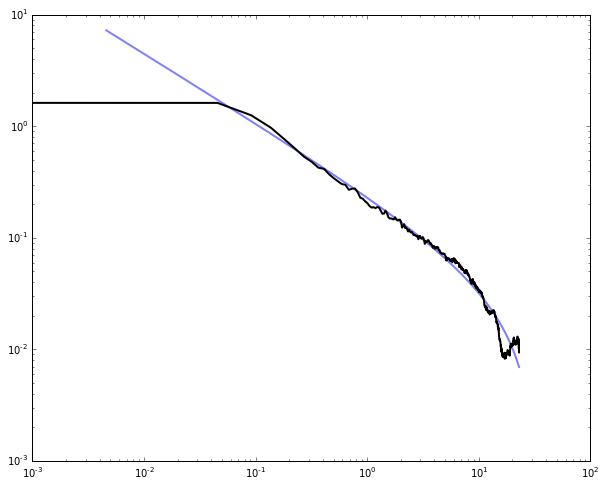

In [443]:
plot(moreFreqs, moreSpectra, 'b', linewidth=2, alpha=0.5)
plot(originalFreqs, new_r0, 'k', linewidth=2)
yscale('log')
xscale('log')

The total noise is 0.010000.


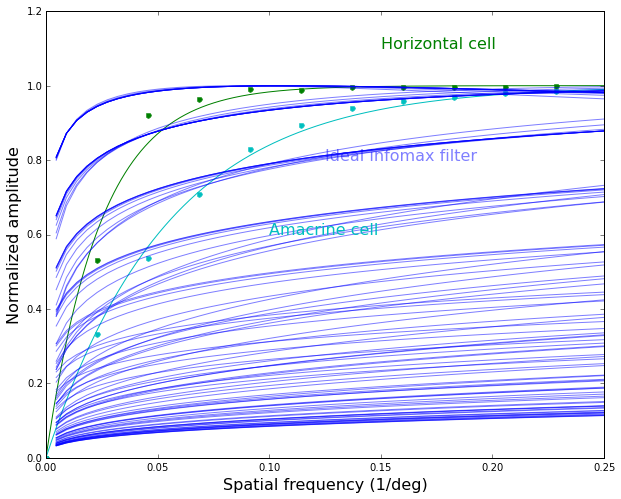

In [455]:
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', markersize=10)
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.', markersize=10)
if flag == 'interp':
    plot(horzInterpolate_x, horzInterpolate(horzInterpolate_x), 'g')
    plot(amaInterpolate_x, amaInterpolate(amaInterpolate_x), 'c')
elif flag == 'exp':
    plot(horzInterpolate_x, horzExpFit, 'g')
    plot(amaInterpolate_x, amaExpFit, 'c')
    
#plot(moreFreqs1, idealFit/np.max(idealFit), 'b', linewidth=3, alpha=0.5)
for k in filts_new.keys():
    plot(moreFreqs, filts_new[k]/np.max(filts_new[k]), 'b', alpha=0.5)

xlim([0,0.25])
xlabel('Spatial frequency (1/deg)', fontsize=16)
ylabel('Normalized amplitude', fontsize=16)
annotate('Amacrine cell', [0.1, 0.6], fontsize=16, color='c')
annotate('Horizontal cell', [0.15, 1.1], fontsize=16, color='g')
annotate('Ideal infomax filter', [0.125, 0.8], fontsize=16, color='b', alpha=0.5)
print 'The total noise is %f.' %(totalNoise)
#mpld3.display()

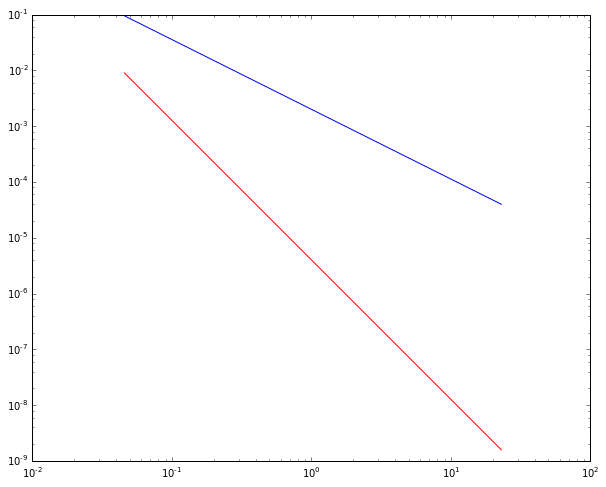

In [445]:
plot(originalFreqs[1:], [0.002/f**1.25 for f in originalFreqs[1:]], 'b')
plot(originalFreqs[1:], [(0.002/f**1.25)**2 for f in originalFreqs[1:]], 'r')
yscale('log')
xscale('log')

## I've relieved some of my worries about the difference between taking F[cov] vs F[x]. Turns out F[cov] = F[x]^2.

In [446]:
inputNoise=.005
outputNoise=.005
totalNoise = inputNoise + outputNoise

moreFreqs1, idealFit, horzOnlyF, horzOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=0.0, horz_weighting=1.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit', originalSpectra=(originalSpectra)**2)
moreFreqs1, idealFit, amaOnlyF, amaOnlyFilter = experimentVsIdeal(inputNoise=inputNoise, outputNoise=outputNoise, surround_weighting=.1, 
                                                       centerWidth=0.5, ama_weighting=1.0, horz_weighting=0.0, 
                                                       center_weighting=0.0, returnFlag=True, plotFlag=False,
                                                       interpolation='fit', originalSpectra=(originalSpectra)**2)

The relative error from this choice of Lagrangian multiplier is nan.
The relative error from this choice of Lagrangian multiplier is nan.


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:20: RuntimeWarning: invalid value encountered in sqrt


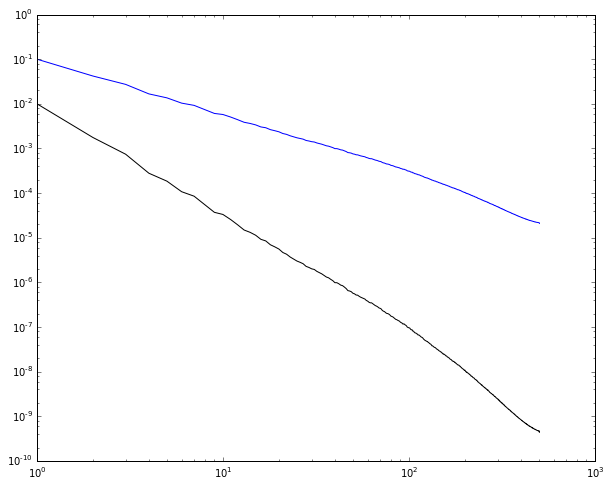

In [447]:
plot(originalSpectra, 'b')
plot(originalSpectra**2,'k')
yscale('log')
xscale('log')

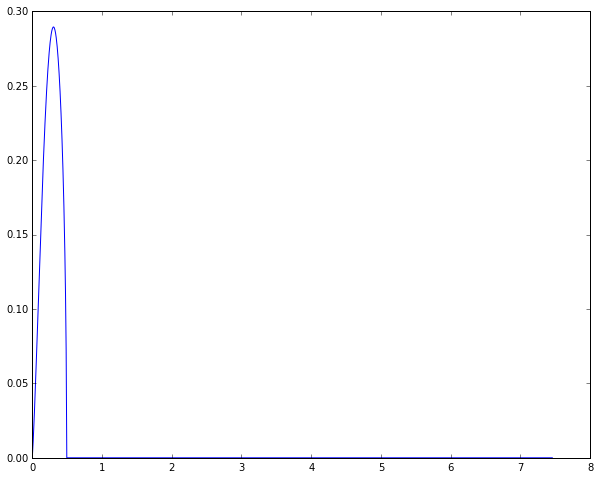

In [448]:
plot(moreFreqs1, idealFit)

In [449]:
lam, err = getLambda(

SyntaxError: unexpected EOF while parsing (<ipython-input-449-0d26a0bef36e>, line 1)

In [450]:
filt = soln(originalSpectra**2, 0.005, 0.005, 10.)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


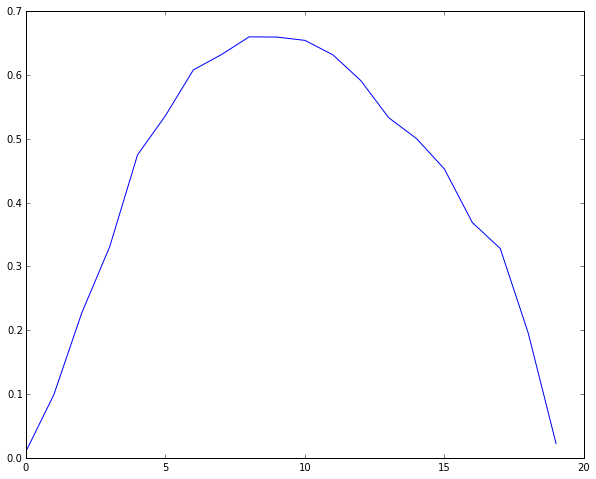

In [451]:
plot(filt)

In [452]:
def getLambda(R_0, inputNoise, outputNoise):
    def lhs(lam):
        return sum(np.log([np.sqrt(r/(2*lam*inputNoise**2))+np.sqrt(1+(r/2*lam*inputNoise**2)) for r in R_0]))
    R = np.array(R_0) + inputNoise**2
    rhs = 0.5*sum(np.log([(r*(inputNoise**2 + outputNoise**2))/(inputNoise**2 * (r + outputNoise**2)) for r in R]))
    
    def difference(lam):
        return abs(lhs(lam)-rhs)
    
    lam = 5*rand(1)
    res = minimize(difference, x0=lam, method='nelder-mead')
    
    return res.x, res.fun

In [453]:
getLambda(originalSpectra**2, 0.025, 0.005)

(array([ 3592.22818804]), 0.7472653894612753)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


(0, 0.25)

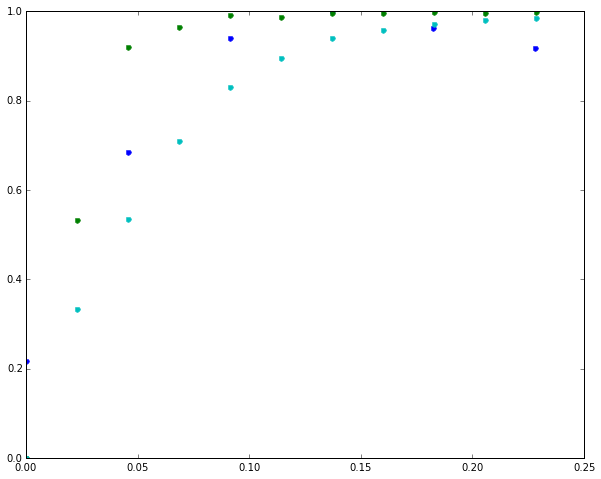

In [454]:
filt = soln(originalSpectra**2, 0.025, 0.005, 192845.89786)
plot(originalFreqs, filt/np.max(filt[~isnan(filt)]), 'b.', markersize=10)
plot(horzOnlyF, 1-horzOnlyFilter/np.max(horzOnlyFilter), 'g.', markersize=10)
plot(amaOnlyF, 1-amaOnlyFilter/np.max(amaOnlyFilter), 'c.', markersize=10)
xlim([0,0.25])